## Latihan Hotel Booking Prediction With Machine Learning ##

Berikut adalah contoh kata pembuka artikel yang merangkum dan mengembangkan poin-poin yang Anda berikan secara lebih detail dan menarik:

---

**Mengantisipasi Pembatalan Booking: Strategi Data-Driven untuk Industri Perhotelan**

Dalam industri perhotelan yang kompetitif, pembatalan reservasi (booking cancellation) bukan sekadar gangguan operasional—ia bisa menjadi sumber kerugian finansial yang signifikan. Oleh karena itu, kemampuan untuk **memprediksi apakah sebuah booking akan dibatalkan atau tidak (is_canceled)** berdasarkan informasi yang tersedia saat pemesanan dilakukan menjadi sangat krusial.

Dengan memahami **masalah bisnis secara mendalam**, kita dapat merancang solusi yang tidak hanya mengurangi kerugian akibat pembatalan, tetapi juga:

- **Mengoptimalkan alokasi kamar dan sumber daya**, sehingga operasional hotel menjadi lebih efisien.
- **Meningkatkan strategi pemasaran dan retensi pelanggan**, dengan memahami karakteristik tamu yang cenderung membatalkan.

Namun, tantangan utama dalam membangun model prediksi pembatalan adalah **ketidakseimbangan data**—jumlah booking yang dibatalkan biasanya jauh lebih sedikit dibandingkan yang tidak. Oleh karena itu, penggunaan **metrik evaluasi yang tepat** sangat penting untuk menilai performa model secara adil dan akurat:

- **Recall**: Mengukur seberapa banyak pembatalan yang berhasil dideteksi oleh model.
- **Precision**: Menilai seberapa akurat prediksi pembatalan yang dilakukan.
- **F1-score**: Memberikan keseimbangan antara precision dan recall.
- **ROC-AUC**: Menunjukkan kemampuan model dalam membedakan antara booking yang akan dibatalkan dan yang tidak.

Dengan pendekatan yang tepat, prediksi pembatalan bukan hanya menjadi alat analitik, tetapi juga strategi bisnis yang dapat meningkatkan profitabilitas dan kepuasan pelanggan.


In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
# from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

## load Data ##

In [2]:
# load dataset
df = pd.read_csv('data_hotel_booking_demand.csv')
df

country market_segment  previous_cancellations  booking_changes  \
0         IRL  Offline TA/TO                       0                0   
1         FRA      Online TA                       0                0   
2         PRT      Online TA                       0                1   
3         NLD      Online TA                       0                0   
4         PRT      Online TA                       0                2   
...       ...            ...                     ...              ...   
83568     PRT      Online TA                       0                0   
83569     FRA      Online TA                       0                0   
83570     PRT      Online TA                       0                1   
83571      CN  Offline TA/TO                       0                0   
83572     PRT         Groups                       0                0   

      deposit_type  days_in_waiting_list    customer_type reserved_room_type  \
0       No Deposit                     0  Transient-Party                  A   
1       No Deposit                     0        Transient                  A   
2       No Deposit                     0        Transient                  A   
3       No Deposit                     0        Transient                  A   
4       No Deposit                     0        Transient                  A   
...            ...                   ...              ...                ...   
83568   No Deposit                     0         Contract                  A   
83569   No Deposit                     0        Transient                  D   
83570   No Deposit                     0        Transient                  D   
83571   No Deposit                     0  Transient-Party                  A   
83572   Non Refund                     0        Transient                  A   

       required_car_parking_spaces  total_of_special_requests  is_canceled  
0                                0                          0            0  
1                                0                          2            0  
2                                0                          2            0  
3                                0                          1            1  
4                                0                          2            0  
...                            ...                        ...          ...  
83568                            0                          3            1  
83569                            0                          2            0  
83570                            0                          3            0  
83571                            0                          0            0  
83572                            0                          0            1  

[83573 rows x 11 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


Fitur:
1. country – negara asal tamu
2. market_segment – segmen pasar
3. previous_cancellations – jumlah pembatalan sebelumnya
4. booking_changes – jumlah perubahan pada booking
5. deposit_type – jenis deposit (no deposit, non-refundable, dll.)
6. days_in_waiting_list – jumlah hari dalam daftar tunggu
7. customer_type – tipe pelanggan (transient, group, dll.)
8. reserved_room_type – tipe kamar yang dipesan
9. required_car_parking_spaces – jumlah tempat parkir yang diminta
10. total_of_special_requests – jumlah permintaan khusus

Target: is_canceled – 0 = tidak dibatalkan, 1 = dibatalkan

In [4]:
# cek missing value
df.isnull().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

In [5]:
# cek duplikasi
df.duplicated().sum()

np.int64(73371)

In [6]:
# cek imbalance dataset
df['is_canceled'].value_counts()

is_canceled
0    52795
1    30778
Name: count, dtype: int64

In [7]:
# cek unique value
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

dataFeatures dataType  null  nullPct  unique  \
0                       country   object   351     0.42     162   
1                market_segment   object     0     0.00       8   
2        previous_cancellations    int64     0     0.00      15   
3               booking_changes    int64     0     0.00      19   
4                  deposit_type   object     0     0.00       3   
5          days_in_waiting_list    int64     0     0.00     115   
6                 customer_type   object     0     0.00       4   
7            reserved_room_type   object     0     0.00      10   
8   required_car_parking_spaces    int64     0     0.00       5   
9     total_of_special_requests    int64     0     0.00       6   
10                  is_canceled    int64     0     0.00       2   

                   uniqueSample  
0                    [UGA, ECU]  
1           [Groups, Corporate]  
2                       [11, 4]  
3                      [16, 20]  
4      [No Deposit, Refundable]  
5                      [27, 44]  
6   [Transient-Party, Contract]  
7                        [D, L]  
8                        [8, 3]  
9                        [4, 3]  
10                       [1, 0]

In [8]:
#cek nan value
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

## Exploration Data Analisys ##

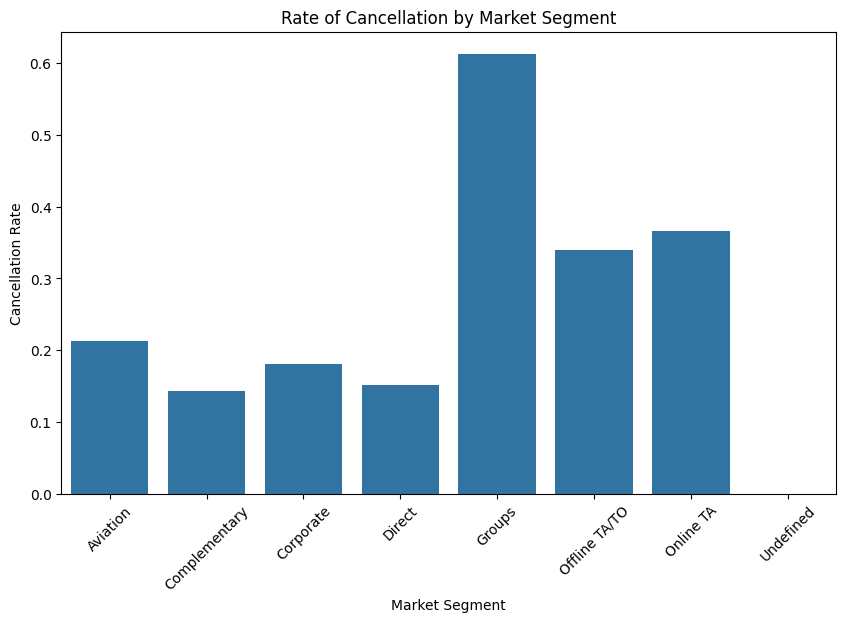

In [9]:
# tampilkan visualisasi antara kolomg market_segment dengan is_canceled dalam bentuk bar plot
# target is_canceled ditransformasi dalam bentuk rate antara 0 dan 1 setiap market_segment
not_canceled = df[df['is_canceled'] == 0].groupby('market_segment').size()
canceled = df[df['is_canceled'] == 1].groupby('market_segment').size()
# hitung rate
rate = canceled / (not_canceled + canceled)
# buat bar plot setiap market_segment mempunyai perbadingan not_canceled dan canceled
plt.figure(figsize=(10, 6))
sns.barplot(x=rate.index, y=rate.values)
plt.title('Rate of Cancellation by Market Segment')
plt.xlabel('Market Segment')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.show()

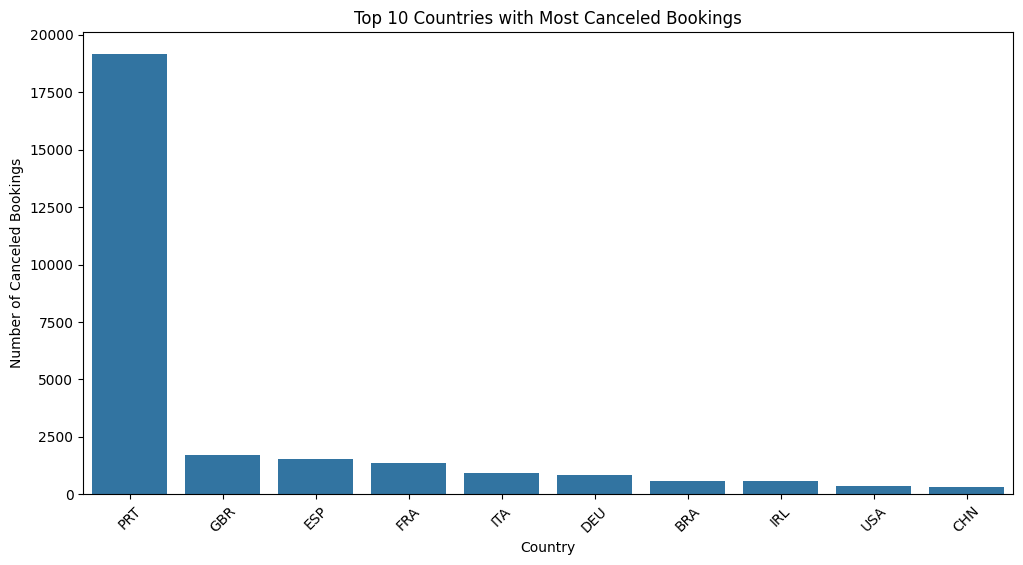

In [10]:
# tampilkan visualisasi 10 country dengan jumlah canceled booking terbanyak
top_countries = df[df['is_canceled'] == 1]['country'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries with Most Canceled Bookings')
plt.xlabel('Country')
plt.ylabel('Number of Canceled Bookings')
plt.xticks(rotation=45)
plt.show()

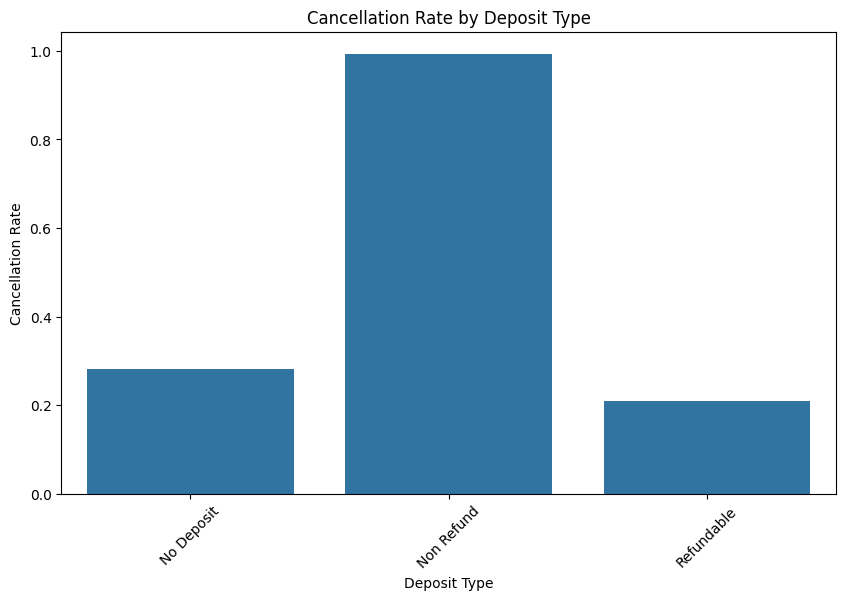

In [11]:
# tampilkan visualiasi deposit_type dengan is_canceled dalam bentuk bar plot
deposit_not_canceled = df[df['is_canceled'] == 0].groupby('deposit_type').size()
deposit_canceled = df[df['is_canceled'] == 1].groupby('deposit_type').size()
# hitung rate
deposit_rate = deposit_canceled / (deposit_not_canceled + deposit_canceled)
# buat bar plot setiap deposit_type mempunyai perbadingan not_canceled dan canceled
plt.figure(figsize=(10, 6))
sns.barplot(x=deposit_rate.index, y=deposit_rate.values)
plt.title('Cancellation Rate by Deposit Type')
plt.xlabel('Deposit Type')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.show()

In [12]:
# cek data deposit_type yang  'Non Refund' 
df[df['deposit_type'] == 'Non Refund'].head(10)



country market_segment  previous_cancellations  booking_changes  \
6      PRT         Groups                       0                0   
7      PRT         Groups                       0                0   
9      PRT         Groups                       1                0   
12     PRT         Groups                       1                0   
14     PRT  Offline TA/TO                       0                0   
22     PRT         Groups                       0                0   
23     PRT  Offline TA/TO                       0                0   
27     PRT  Offline TA/TO                       0                0   
34     PRT         Groups                       0                0   
44     PRT         Groups                       0                0   

   deposit_type  days_in_waiting_list customer_type reserved_room_type  \
6    Non Refund                     0     Transient                  A   
7    Non Refund                     0     Transient                  A   
9    Non Refund                     0      Contract                  A   
12   Non Refund                     0     Transient                  A   
14   Non Refund                     3     Transient                  A   
22   Non Refund                     0     Transient                  A   
23   Non Refund                    39     Transient                  A   
27   Non Refund                     0     Transient                  A   
34   Non Refund                     0     Transient                  A   
44   Non Refund                     0     Transient                  A   

    required_car_parking_spaces  total_of_special_requests  is_canceled  
6                             0                          0            1  
7                             0                          0            1  
9                             0                          0            1  
12                            0                          0            1  
14                            0                          0            1  
22                            0                          0            1  
23                            0                          0            1  
27                            0                          0            1  
34                            0                          0            1  
44                            0                          0            1

In [13]:
# cek data unique value dari target is_canceled dengan deposit_type yang  'Non Refund' 
df[df['deposit_type'] == 'Non Refund']['is_canceled'].value_counts()


is_canceled
1    10048
0       63
Name: count, dtype: int64

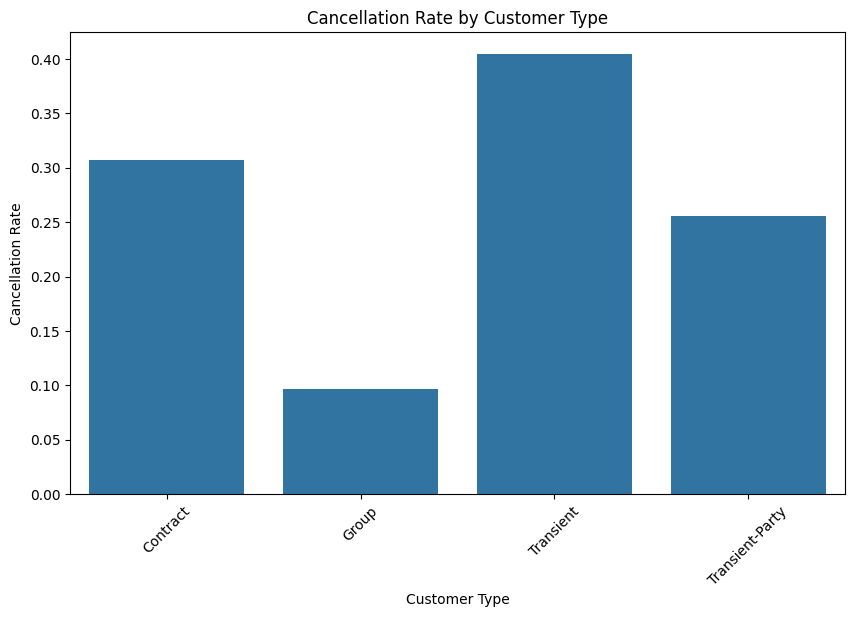

In [15]:
# tampilkan visualiasi customer_type dengan is_canceled dalam bentuk bar plot
customer_not_canceled = df[df['is_canceled'] == 0].groupby('customer_type').size()
customer_canceled = df[df['is_canceled'] == 1].groupby('customer_type').size()
# hitung rate
customer_rate = customer_canceled / (customer_not_canceled + customer_canceled)
# buat bar plot setiap customer_type mempunyai perbadingan not_canceled dan canceled
plt.figure(figsize=(10, 6))
sns.barplot(x=customer_rate.index, y=customer_rate.values)
plt.title('Cancellation Rate by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.show()

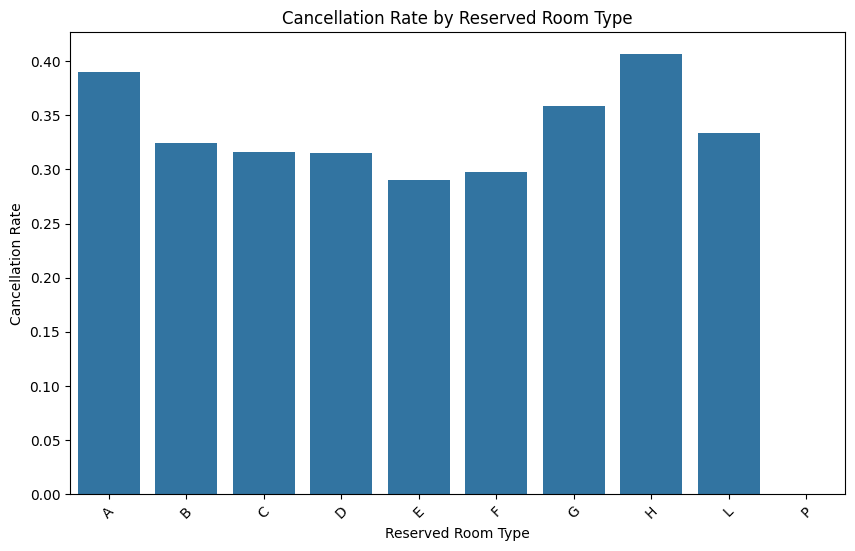

In [16]:
# tampilkan visualiasi reserved_room_type dengan is_canceled dalam bentuk bar plot
reserved_not_canceled = df[df['is_canceled'] == 0].groupby('reserved_room_type').size()
reserved_canceled = df[df['is_canceled'] == 1].groupby('reserved_room_type').size()
# hitung rate
reserved_rate = reserved_canceled / (reserved_not_canceled + reserved_canceled)
# buat bar plot setiap reserved_room_type mempunyai perbadingan not_canceled dan canceled
plt.figure(figsize=(10, 6))
sns.barplot(x=reserved_rate.index, y=reserved_rate.values)
plt.title('Cancellation Rate by Reserved Room Type')
plt.xlabel('Reserved Room Type')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.show()

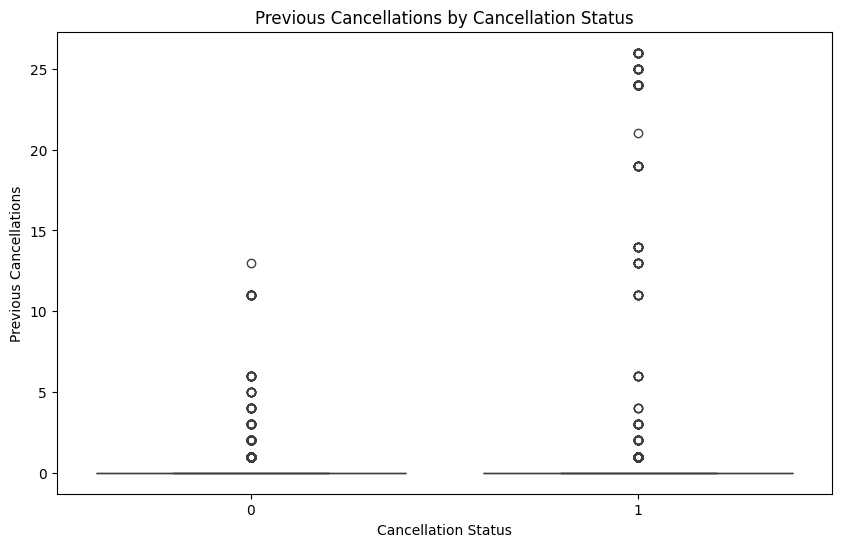

In [ ]:
# tampilkan visualiasi boxplot dari previous_cancellations 
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='previous_cancellations', data=df)
plt.title('Previous Cancellations by Cancellation Status')
plt.xlabel('Cancellation Status')
plt.ylabel('Previous Cancellations')
plt.show()


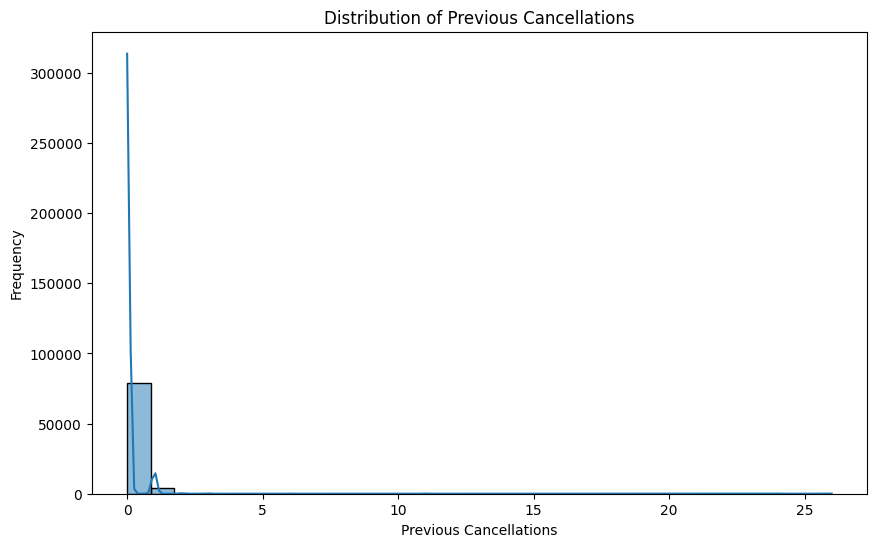

In [18]:
# tampilkan visualiasi histogram dari previous_cancellations 
plt.figure(figsize=(10, 6))
sns.histplot(df['previous_cancellations'], bins=30, kde=True)
plt.title('Distribution of Previous Cancellations')
plt.xlabel('Previous Cancellations')
plt.ylabel('Frequency')
plt.show()

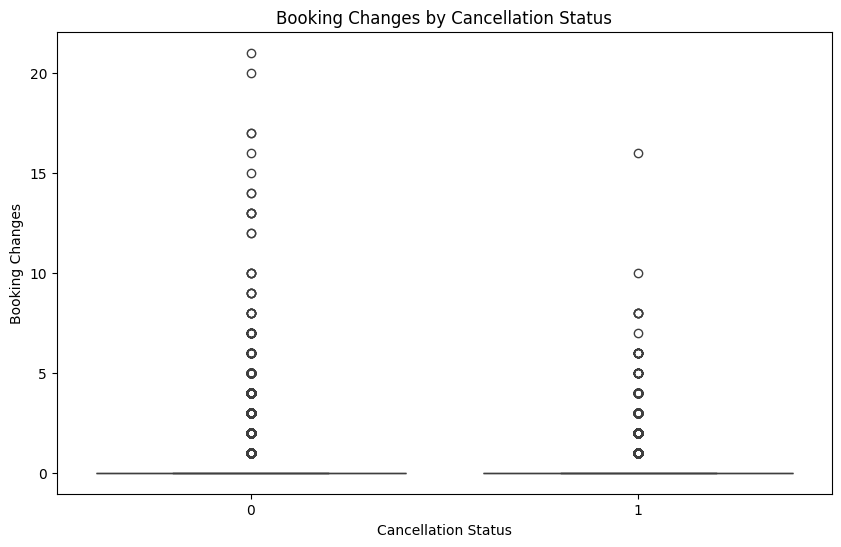

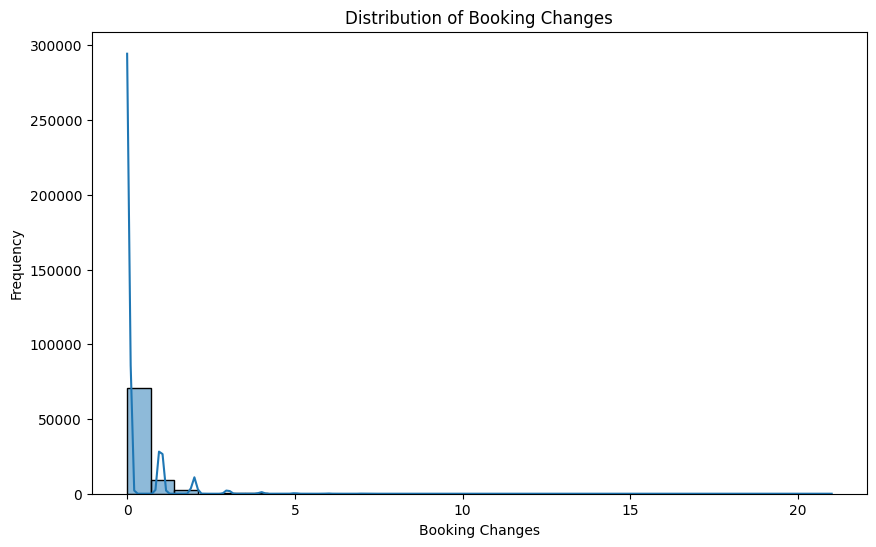

In [19]:
# buat visualisasi boxplot dan histogram dari booking_changes
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='booking_changes', data=df)
plt.title('Booking Changes by Cancellation Status')
plt.xlabel('Cancellation Status')
plt.ylabel('Booking Changes')
plt.show()
# tampilkan visualisasi histogram dari booking_changes
plt.figure(figsize=(10, 6))
sns.histplot(df['booking_changes'], bins=30, kde=True)
plt.title('Distribution of Booking Changes')
plt.xlabel('Booking Changes')
plt.ylabel('Frequency')
plt.show()


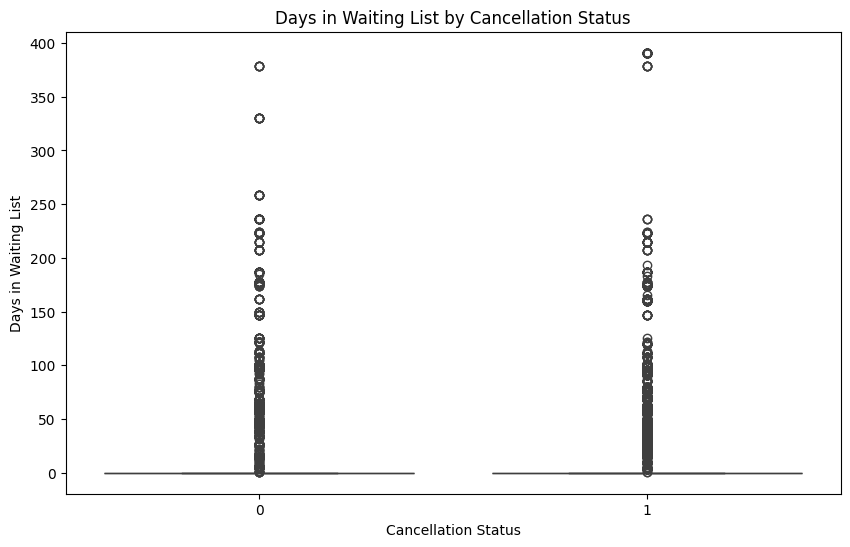

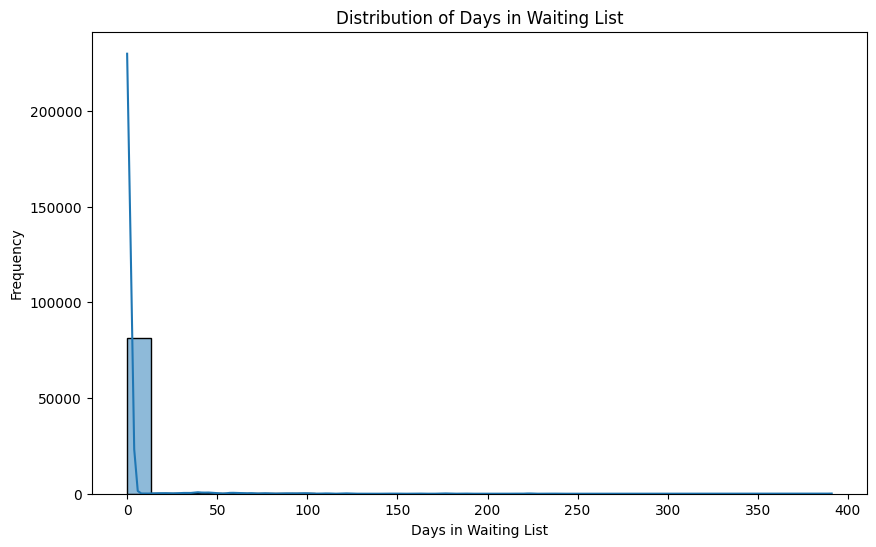

In [20]:
# buat visualisasi boxplot dan histogram dari days_in_waiting_list
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_canceled', y='days_in_waiting_list', data=df)
plt.title('Days in Waiting List by Cancellation Status')
plt.xlabel('Cancellation Status')
plt.ylabel('Days in Waiting List')
plt.show()
# tampilkan visualisasi histogram dari days_in_waiting_list
plt.figure(figsize=(10, 6))
sns.histplot(df['days_in_waiting_list'], bins=30, kde=True)
plt.title('Distribution of Days in Waiting List')
plt.xlabel('Days in Waiting List')
plt.ylabel('Frequency')
plt.show()  

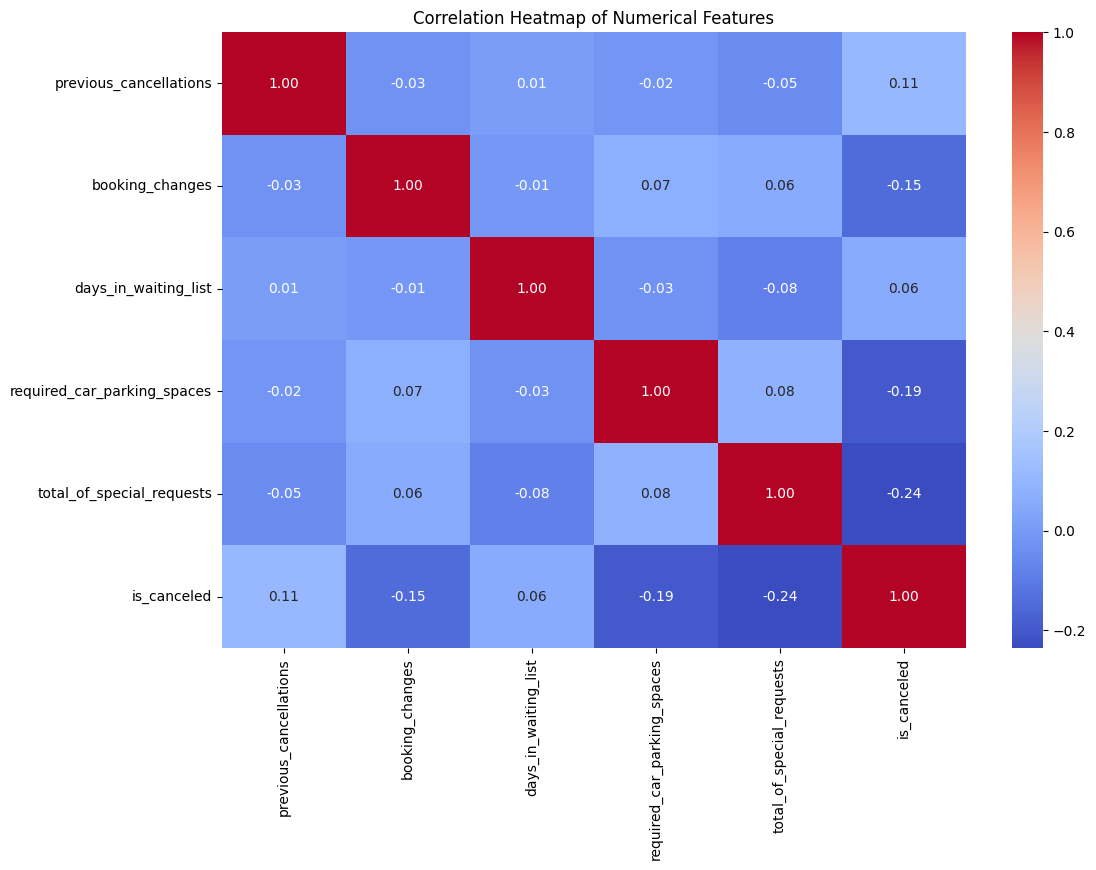

In [14]:
# buat heatmap korelasi antar fitur numerik saja : previous_cancellations, booking_changes, days_in_waiting_list, required_car_parking_spaces, total_of_special_requests
plt.figure(figsize=(12, 8))
sns.heatmap(df[['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 
                'required_car_parking_spaces', 'total_of_special_requests', 'is_canceled']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

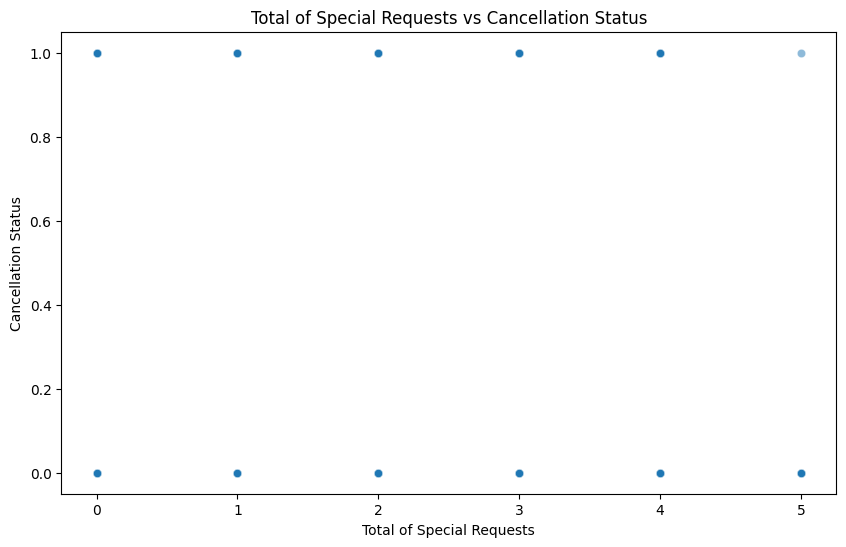

In [21]:
# buat visualisasi scatter plot antara total_of_special_requests dan is_canceled
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_of_special_requests', y='is_canceled', data=df, alpha=0.5)
plt.title('Total of Special Requests vs Cancellation Status')
plt.xlabel('Total of Special Requests')
plt.ylabel('Cancellation Status')
plt.show()

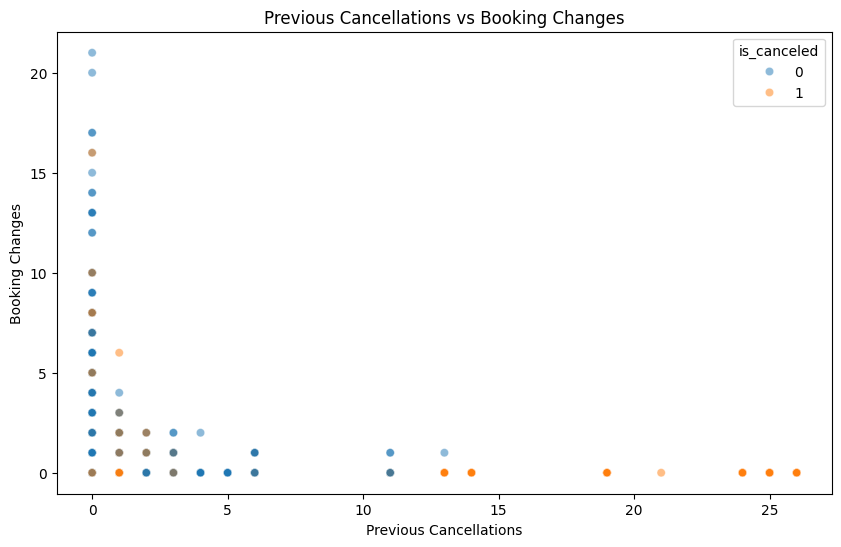

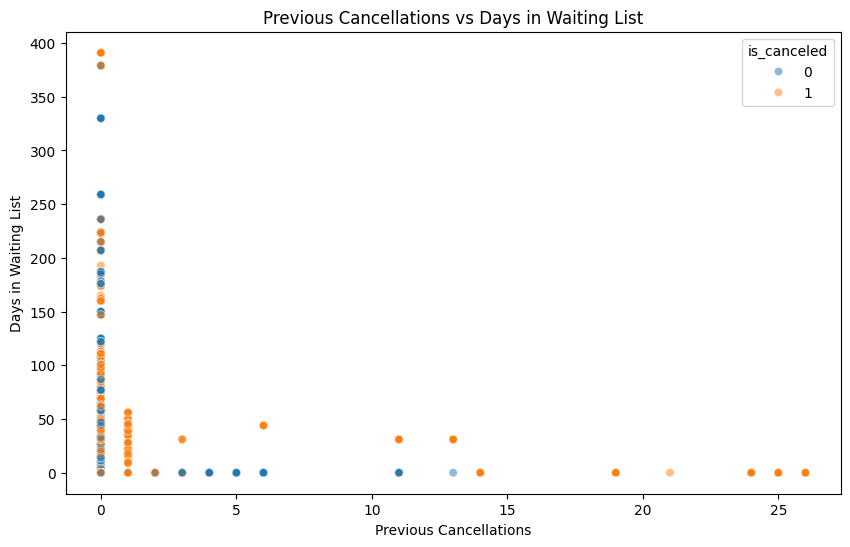

In [24]:
# buat visualisasi scatter plot antara previous_cancellations dan booking_changes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='previous_cancellations', y='booking_changes', data=df, alpha=0.5, hue='is_canceled')
plt.title('Previous Cancellations vs Booking Changes')
plt.xlabel('Previous Cancellations')
plt.ylabel('Booking Changes')
plt.show()  
# buat visualisasi scatter plot antara previous_cancellations dan days_in_waiting_list
plt.figure(figsize=(10, 6))
sns.scatterplot(x='previous_cancellations', y='days_in_waiting_list', data=df, alpha=0.5, hue='is_canceled')
plt.title('Previous Cancellations vs Days in Waiting List')
plt.xlabel('Previous Cancellations')
plt.ylabel('Days in Waiting List')
plt.show()

## preprocessing ##

In [25]:
# preprocessing
# pisahkan fitur dan target
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']
# pisahkan fitur numerik dan kategorikal
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()


In [27]:
# import robust scaler
from sklearn.preprocessing import RobustScaler

In [ ]:
# preprocessing pipeline
# buat preprocessing pipeline untuk fitur numerik
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', RobustScaler())  # Scale features
])
# buat preprocessing pipeline untuk fitur kategorikal
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])
# buat preprocessing pipeline untuk fitur numerik dan kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)
# buat preprocessing pipeline untuk fitur numerik dan kategorikal dengan oversampling
preprocessor_oversample = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('oversample', RandomOverSampler())  # Oversample the minority class
])
# buat preprocessing untuk fitur kategorkal dengan banyak kategori dengan binary encoding
cat_transformer_binary = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
    ('encoder', ce.BinaryEncoder())  # Binary encode categorical features
])
# buat preprocessing pipeline untuk fitur kategorikal dengan one hot encoding
cat_transformer_onehot = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

In [26]:
df.head()

country market_segment  previous_cancellations  booking_changes  \
0     IRL  Offline TA/TO                       0                0   
1     FRA      Online TA                       0                0   
2     PRT      Online TA                       0                1   
3     NLD      Online TA                       0                0   
4     PRT      Online TA                       0                2   

  deposit_type  days_in_waiting_list    customer_type reserved_room_type  \
0   No Deposit                     0  Transient-Party                  A   
1   No Deposit                     0        Transient                  A   
2   No Deposit                     0        Transient                  A   
3   No Deposit                     0        Transient                  A   
4   No Deposit                     0        Transient                  A   

   required_car_parking_spaces  total_of_special_requests  is_canceled  
0                            0                          0            0  
1                            0                          2            0  
2                            0                          2            0  
3                            0                          1            1  
4                            0                          2            0

In [29]:
# cek unique value
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

dataFeatures dataType  null  nullPct  unique  \
0                       country   object   351     0.42     162   
1                market_segment   object     0     0.00       8   
2        previous_cancellations    int64     0     0.00      15   
3               booking_changes    int64     0     0.00      19   
4                  deposit_type   object     0     0.00       3   
5          days_in_waiting_list    int64     0     0.00     115   
6                 customer_type   object     0     0.00       4   
7            reserved_room_type   object     0     0.00      10   
8   required_car_parking_spaces    int64     0     0.00       5   
9     total_of_special_requests    int64     0     0.00       6   
10                  is_canceled    int64     0     0.00       2   

                  uniqueSample  
0                   [SWE, CHN]  
1   [Offline TA/TO, Corporate]  
2                     [13, 19]  
3                      [14, 7]  
4     [No Deposit, Non Refund]  
5                    [160, 77]  
6            [Group, Contract]  
7                       [C, E]  
8                       [0, 3]  
9                       [3, 4]  
10                      [1, 0]

In [30]:
# buat transformasi untuk fitur numerik dan kategorikal dengan oversampling
preprocessor_oversample = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('cat_binary', cat_transformer_binary, ['country']),  # Fitur kategorikal dengan banyak kategori
        ('cat_onehot', cat_transformer_onehot, ['deposit_type', 'market_segment','customer_type']) # Fitur kategorikal dengan one hot encoding
    ]
)


In [31]:
preprocessor_oversample

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unkno...
                                  'customer_type', 'reserved_room_type']),
                                ('cat_binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', BinaryEncoder())]),
                                 ['country']),
                                ('cat_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['deposit_type', 'market_segment',
                                  'customer_type'])])

In [32]:
#pisahkan test dan train
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)  # Stratify to maintain the same distribution of target variable in train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# preprocessing pipeline
preprocessor_oversample.fit(X_train, y_train)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unkno...
                                  'customer_type', 'reserved_room_type']),
                                ('cat_binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder', BinaryEncoder())]),
                                 ['country']),
                                ('cat_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['deposit_type', 'market_segment',
                                  'customer_type'])])

In [ ]:
# tampilkan data yang sudah di preprocessing
X_train_transformed = preprocessor_oversample.transform(X_train)
X_test_transformed = preprocessor_oversample.transform(X_test)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 173465 stored elements and shape (16715, 210)>

## Modeling & Evaluation ##

In [42]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

In [46]:
# buat list model
models = {
    'Logistic Regression': logreg,
    'K-Nearest Neighbors': knn,
    'Decision Tree': dt,
    'Random Forest': rf,
    'XGBoost': xgb,
    'LightGBM': lgbm
}
# buat fungsi untuk evaluasi model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)
# evaluasi setiap model
for name, model in models.items(): 
    print(f"Evaluating {name}...")
    evaluate_model(model, X_train_transformed, y_train, X_test_transformed, y_test)
    print("\n" + "=" * 50 + "\n")
# Evaluasi model dengan cross-validation
for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='f1')
    print(f"{name} Cross-Validation F1 Scores: {scores}")
    print(f"{name} Mean F1 Score: {np.mean(scores):.4f}\n")
# Evaluasi model dengan cross-validation
for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy Scores: {scores}")
    print(f"{name} Mean Accuracy Score: {np.mean(scores):.4f}\n")
# Evaluasi model dengan cross-validation
for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='recall')
    print(f"{name} Cross-Validation Recall Scores: {scores}")
    print(f"{name} Mean Recall Score: {np.mean(scores):.4f}\n")
# Evaluasi model dengan cross-validation
for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='precision')
    print(f"{name} Cross-Validation Precision Scores: {scores}")
    print(f"{name} Mean Precision Score: {np.mean(scores):.4f}\n")  


Evaluating Logistic Regression...
Model: LogisticRegression
F1 Score: 0.6523
Accuracy: 0.7824
Recall: 0.5544
Precision: 0.7922

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.92      0.84     10559
           1       0.79      0.55      0.65      6156

    accuracy                           0.78     16715
   macro avg       0.79      0.73      0.75     16715
weighted avg       0.78      0.78      0.77     16715


Confusion Matrix:
[[9664  895]
 [2743 3413]]
--------------------------------------------------


Evaluating K-Nearest Neighbors...
Model: KNeighborsClassifier
F1 Score: 0.6812
Accuracy: 0.7897
Recall: 0.6101
Precision: 0.7711

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     10559
           1       0.77      0.61      0.68      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.75      0.76     1671

Berikut adalah matrix yang didapatkan:

```
[[9664  895]
 [2743 3413]]
```

Mari kita uraikan dan jelaskan secara detail:

---

## 📊 **Confusion Matrix Breakdown**

|                | Predicted: Tidak Cancel (0) | Predicted: Cancel (1) |
|----------------|-----------------------------|------------------------|
| Actual: Tidak Cancel (0) | **TN = 9664**               | **FP = 895**              |
| Actual: Cancel (1)       | **FN = 2743**               | **TP = 3413**             |

### ✅ **True Positive (TP = 3413)**
- Booking yang **sebenarnya dibatalkan** dan **diprediksi dibatalkan** oleh model.
- Ini adalah prediksi yang benar untuk kelas **cancel**.

### ✅ **True Negative (TN = 9664)**
- Booking yang **sebenarnya tidak dibatalkan** dan **diprediksi tidak dibatalkan** oleh model.
- Ini adalah prediksi yang benar untuk kelas **tidak cancel**.

### ❌ **False Positive (FP = 895)**
- Booking yang **sebenarnya tidak dibatalkan**, tapi **diprediksi akan dibatalkan** oleh model.
- Ini adalah kesalahan di mana model terlalu pesimis.

### ❌ **False Negative (FN = 2743)**
- Booking yang **sebenarnya dibatalkan**, tapi **diprediksi tidak dibatalkan** oleh model.
- Ini adalah kesalahan di mana model terlalu optimis.

---

## 📈 **Scoring yang Tepat**

Karena data kamu **tidak seimbang**, maka **akurasi saja tidak cukup**. Berikut metrik yang lebih informatif:

### 1. **Accuracy**
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{3413 + 9664}{3413 + 9664 + 895 + 2743} \approx 76.6\%
$$

### 2. **Precision (untuk kelas cancel)**
$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{3413}{3413 + 895} \approx 79.2\%
$$
> Seberapa banyak prediksi cancel yang benar-benar cancel.

### 3. **Recall (Sensitivity)**
$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{3413}{3413 + 2743} \approx 55.4\%
$$
> Seberapa banyak kasus cancel yang berhasil ditangkap oleh model.

### 4. **F1-Score**
$$
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} \approx 65.3\%
$$
> Kombinasi harmonis antara precision dan recall.





## 📊 **Perbandingan Recall Score**

| Algoritma             | Mean Recall Score |
|-----------------------|-------------------|
| Logistic Regression   | 0.5580            |
| K-Nearest Neighbors   | 0.6558            |
| Decision Tree         | 0.6914            |
| Random Forest         | **0.6960**        |
| XGBoost               | 0.6773            |
| LightGBM              | 0.6842            |

---

## ✅ **Model Terbaik Berdasarkan Recall**
- **Random Forest** memiliki **mean recall tertinggi** yaitu **0.6960**.
- Ini berarti model tersebut paling baik dalam **mendeteksi kasus pembatalan** dibandingkan model lainnya.

---

## 🔍 **Pertimbangan Tambahan**

1. **Overfitting**:
   - Decision Tree dan Random Forest bisa overfit jika tidak diatur dengan baik.
   - Cek juga **recall di data validasi/test**, bukan hanya training.

2. **Waktu dan Resource**:
   - Random Forest dan LightGBM lebih cepat dibanding XGBoost.
   - Logistic Regression dan KNN lebih ringan, tapi performanya lebih rendah.

3. **Metrik Lain**:
   - Lihat juga **precision**, **F1-score**, dan **ROC-AUC** untuk gambaran menyeluruh.

4. **Interpretabilitas**:
   - Logistic Regression lebih mudah dijelaskan ke stakeholder.
   - Random Forest dan LightGBM bisa memberikan **feature importance** yang berguna.


## Model Benchmarking : Test Data ##

In [47]:
# Model Benchmarking : Test Data
models_benchmark = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier()
}
# Model Benchmarking : Test Data
def benchmark_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        
        results[name] = {
            'F1 Score': f1,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision
        }
    return pd.DataFrame(results).T  
benchmark_results = benchmark_models(models_benchmark, X_train_transformed, y_train, X_test_transformed, y_test)
benchmark_results.sort_values(by='F1 Score', ascending=False, inplace=True)
benchmark_results


[LightGBM] [Info] Number of positive: 24622, number of negative: 42236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 66858, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368273 -> initscore=-0.539633
[LightGBM] [Info] Start training from score -0.539633


F1 Score  Accuracy    Recall  Precision
Random Forest        0.725295  0.805085  0.698668   0.754032
LightGBM             0.724815  0.808794  0.683723   0.771162
Decision Tree        0.720991  0.803350  0.689896   0.755022
XGBoost              0.719474  0.808675  0.666179   0.782037
K-Nearest Neighbors  0.681237  0.789710  0.610136   0.771094
Logistic Regression  0.652332  0.782351  0.554418   0.792247



## 📊 **Hasil Benchmark pada Test Data**

| Model                | Recall     | Precision  |
|---------------------|------------|------------|
| Random Forest        | **0.6987** | 0.7540     |
| LightGBM             | 0.6837     | 0.7712     |
| Decision Tree        | 0.6899     | 0.7550     |
| XGBoost              | 0.6662     | **0.7820** |
| K-Nearest Neighbors  | 0.6101     | 0.7711     |
| Logistic Regression  | 0.5544     | **0.7922** |

---

## 🔍 **Perbandingan Train vs Test**

### 1. **Stabilitas Model**
- **Random Forest, LightGBM, dan Decision Tree** menunjukkan performa **yang konsisten** antara training dan test data.
- Ini menunjukkan bahwa model **tidak overfitting**, dan mampu **menggeneralisasi dengan baik**.

### 2. **Model dengan Recall Tinggi**
- **Random Forest** tetap menjadi model dengan **recall tertinggi** di test data (0.6987), artinya paling baik dalam **mendeteksi pembatalan**.
- **Decision Tree** dan **LightGBM** juga cukup dekat, menunjukkan performa yang stabil.

### 3. **Model dengan Precision Tinggi**
- **Logistic Regression** dan **XGBoost** memiliki **precision tertinggi**, artinya prediksi pembatalannya lebih akurat, tapi mereka **mengorbankan recall** (banyak pembatalan yang tidak terdeteksi).

---

## ⚖️ **Trade-off dan Pilihan Model**

| Tujuan Bisnis                          | Model yang Cocok              |
|----------------------------------------|-------------------------------|
| Menangkap sebanyak mungkin pembatalan | **Random Forest / LightGBM** |
| Menghindari false alarm                | **Logistic Regression / XGBoost** |
| Keseimbangan precision & recall        | **LightGBM / XGBoost**        |

---

## ✅ **Rekomendasi**
Poin yang harus dipertimbangkan :
- **Mengurangi risiko pembatalan** → **Random Forest** atau **LightGBM**
- **Menghindari salah prediksi cancel** → **XGBoost** atau **Logistic Regression**
- **Model cepat dan efisien** → **LightGBM**


[LightGBM] [Info] Number of positive: 24622, number of negative: 42236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 66858, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368273 -> initscore=-0.539633
[LightGBM] [Info] Start training from score -0.539633


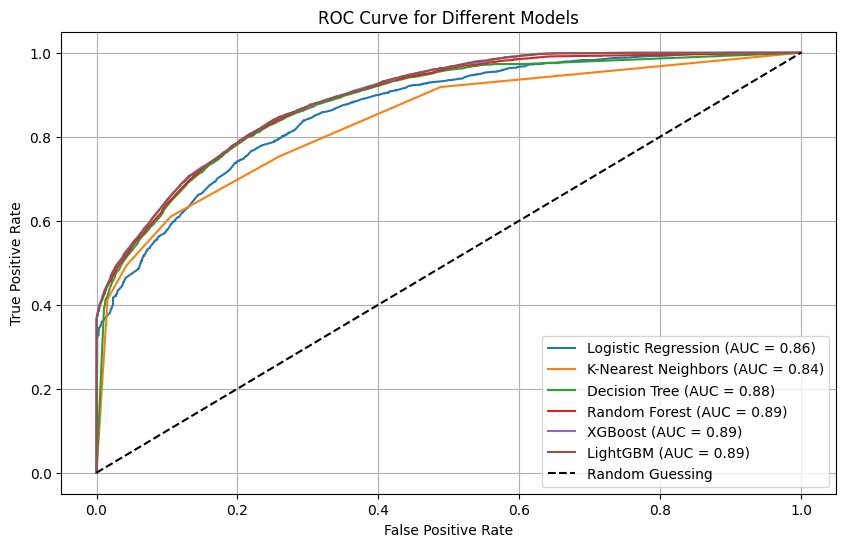

In [60]:
# hitung  ROC Curve dan AUC
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve_for_models(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title('ROC Curve for Different Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()
# plot ROC Curve for each model
plot_roc_curve_for_models(models_benchmark, X_train_transformed, y_train, X_test_transformed, y_test)
# plot ROC Curve for each model with cross-validation
def plot_roc_curve_with_cv(models, X_train, y_train, cv=5):
    plt.figure(figsize=(10, 6))
    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
        mean_auc = np.mean(cv_scores)
        fpr, tpr, _ = roc_curve(y_train, model.fit(X_train, y_train).predict_proba(X_train)[:, 1])
        plt.plot(fpr, tpr, label=f'{name} (Mean AUC = {mean_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title('ROC Curve with Cross-Validation for Different Models')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

### Test Oversampling with K-Fold Cross Validation ###

In [63]:
# Test Oversampling with K-Fold Cross Validation
from imblearn.pipeline import Pipeline as ImbPipeline

# Create a pipeline that includes both preprocessing and oversampling
oversample_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_oversample),
    ('oversample', RandomOverSampler())
])

def test_oversampling_with_kfold(models, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    results = {}

    for name, model in models.items():
        f1_scores = []
        accuracy_scores = []
        recall_scores = []
        precision_scores = []

        for train_index, test_index in skf.split(X, y):
            X_train_fold = X.iloc[train_index]
            X_test_fold = X.iloc[test_index]
            y_train_fold = y.iloc[train_index]
            y_test_fold = y.iloc[test_index]

            # Preprocessing and oversampling
            X_train_resampled, y_train_resampled = oversample_pipeline.fit_resample(X_train_fold, y_train_fold)
            # Only transform the test set (no oversampling)
            X_test_processed = oversample_pipeline.named_steps['preprocessor'].transform(X_test_fold)

            model.fit(X_train_resampled, y_train_resampled)
            y_pred = model.predict(X_test_processed)

            f1_scores.append(f1_score(y_test_fold, y_pred))
            accuracy_scores.append(accuracy_score(y_test_fold, y_pred))
            recall_scores.append(recall_score(y_test_fold, y_pred))
            precision_scores.append(precision_score(y_test_fold, y_pred))

        results[name] = {
            'F1 Score': np.mean(f1_scores),
            'Accuracy': np.mean(accuracy_scores),
            'Recall': np.mean(recall_scores),
            'Precision': np.mean(precision_scores)
        }

    return pd.DataFrame(results).T

# Test Oversampling with K-Fold Cross Validation
test_oversampling_results = test_oversampling_with_kfold(models_benchmark, X_train, y_train, n_splits=5)
test_oversampling_results.sort_values(by='F1 Score', ascending=False, inplace=True)
test_oversampling_results

[LightGBM] [Info] Number of positive: 33788, number of negative: 33788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 67576, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33789, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 67578, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

F1 Score  Accuracy    Recall  Precision
LightGBM             0.744217  0.798080  0.797702   0.697485
XGBoost              0.744116  0.798887  0.794087   0.700105
Random Forest        0.739352  0.790481  0.806962   0.682223
Decision Tree        0.736765  0.789614  0.799529   0.683179
Logistic Regression  0.715464  0.780251  0.750224   0.683839
K-Nearest Neighbors  0.699064  0.760193  0.757451   0.650866



## 📊 **Hasil Oversampling + K-Fold CV**

| Model                | Recall     | Precision  |
|---------------------|------------|------------|
| Random Forest        | **0.8069** | 0.6822     |
| LightGBM             | 0.7977     | 0.6975     |
| Decision Tree        | 0.7995     | 0.6832     |
| XGBoost              | 0.7941     | **0.7001** |
| K-Nearest Neighbors  | 0.7575     | 0.6509     |
| Logistic Regression  | 0.7502     | 0.6838     |

---

## 🔍 **Penjelasan dan Analisis**

### 1. **Recall Meningkat**
- Setelah oversampling, semua model menunjukkan **peningkatan recall** dibanding sebelumnya.
- Ini menunjukkan bahwa oversampling berhasil membantu model **mendeteksi lebih banyak kasus pembatalan** (kelas minoritas).

### 2. **Precision Menurun Sedikit**
- Precision sedikit menurun karena model sekarang **lebih agresif** dalam memprediksi cancel.
- Ini adalah **trade-off yang wajar** saat meningkatkan recall.

### 3. **Model Terbaik Secara Recall**
- **Random Forest** memiliki **recall tertinggi** (0.8069), artinya paling banyak mendeteksi pembatalan.
- Cocok jika tujuan kamu adalah **mengurangi risiko pembatalan sebanyak mungkin**.

### 4. **Model Terbaik Secara Precision**
- **XGBoost** memiliki **precision tertinggi** (0.7001), artinya prediksi pembatalannya paling akurat.
- Cocok jika kamu ingin **menghindari false alarm**.

---

## ⚖️ **Trade-off dan Rekomendasi**

| Tujuan Bisnis                          | Model yang Cocok              |
|----------------------------------------|-------------------------------|
| Menangkap sebanyak mungkin pembatalan | **Random Forest / Decision Tree** |
| Menghindari salah prediksi cancel      | **XGBoost / LightGBM**        |
| Keseimbangan precision & recall        | **LightGBM / XGBoost**        |


In [65]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

# Function to calculate training and validation errors
def calculate_errors(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    train_error = 1 - accuracy_score(y_train, train_pred)
    val_error = 1 - accuracy_score(y_val, val_pred)

    return train_error, val_error
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_transformed, y_train, test_size=0.2, random_state=0, stratify=y_train
)
# Calculate errors without oversampling
for name, model in models_benchmark.items():
    train_error, val_error = calculate_errors(model, X_train_split, y_train_split, X_val_split, y_val_split)
    train_errors_without_oversampling.append(train_error)
    validation_errors_without_oversampling.append(val_error)
# Calculate errors with oversampling
for name, model in models_benchmark.items():
    # Create a new pipeline with oversampling and the model
    oversample_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor_oversample),
        ('oversample', RandomOverSampler()),
        ('model', model)
    ])
    # Use the original DataFrame for splitting, since the pipeline expects DataFrame input
    X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(
        X_train, y_train, test_size=0.2, random_state=0, stratify=y_train
    )
    oversample_pipeline.fit(X_train_os, y_train_os)
    train_pred = oversample_pipeline.predict(X_train_os)
    val_pred = oversample_pipeline.predict(X_val_os)
    train_error = 1 - accuracy_score(y_train_os, train_pred)
    val_error = 1 - accuracy_score(y_val_os, val_pred)
    train_errors_with_oversampling.append(train_error)
    validation_errors_with_oversampling.append(val_error)
# Create a DataFrame to compare errors
error_comparison_df = pd.DataFrame({
    'Model': list(models_benchmark.keys()),
    'Train Error (Without Oversampling)': train_errors_without_oversampling,
    'Validation Error (Without Oversampling)': validation_errors_without_oversampling,
    'Train Error (With Oversampling)': train_errors_with_oversampling,
    'Validation Error (With Oversampling)': validation_errors_with_oversampling
})
error_comparison_df.set_index('Model', inplace=True)
error_comparison_df.sort_values(by='Validation Error (With Oversampling)', ascending=True, inplace=True)
error_comparison_df


[LightGBM] [Info] Number of positive: 19697, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 53486, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368265 -> initscore=-0.539669
[LightGBM] [Info] Start training from score -0.539669
[LightGBM] [Info] Number of positive: 33789, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 67578, number of used features: 113
[LightGBM] [Info] 

Train Error (Without Oversampling)  \
Model                                                     
LightGBM                                       0.183487   
XGBoost                                        0.182403   
Random Forest                                  0.170175   
Decision Tree                                  0.170175   
Logistic Regression                            0.214467   
K-Nearest Neighbors                            0.215683   

                     Validation Error (Without Oversampling)  \
Model                                                          
LightGBM                                            0.185088   
XGBoost                                             0.185986   
Random Forest                                       0.190772   
Decision Tree                                       0.192193   
Logistic Regression                                 0.218292   
K-Nearest Neighbors                                 0.231454   

                     Train Error (With Oversampling)  \
Model                                                  
LightGBM                                    0.197753   
XGBoost                                     0.195266   
Random Forest                               0.185974   
Decision Tree                               0.184198   
Logistic Regression                         0.218730   
K-Nearest Neighbors                         0.213046   

                     Validation Error (With Oversampling)  
Model                                                      
LightGBM                                         0.202662  
XGBoost                                          0.202662  
Random Forest                                    0.210365  
Decision Tree                                    0.212085  
Logistic Regression                              0.222031  
K-Nearest Neighbors                              0.227490



## 📊 **Ringkasan Error Rate**

### 🔹 **Tanpa Oversampling**

| Model                | Train Error | Validation Error |
|---------------------|-------------|------------------|
| LightGBM             | 0.1835      | **0.1851**       |
| XGBoost              | 0.1824      | 0.1860           |
| Random Forest        | **0.1702**  | 0.1908           |
| Decision Tree        | 0.1702      | 0.1922           |
| Logistic Regression  | 0.2145      | 0.2183           |
| KNN                  | 0.2157      | 0.2315           |

### 🔹 **Dengan Oversampling**

| Model                | Train Error | Validation Error |
|---------------------|-------------|------------------|
| LightGBM             | 0.1978      | **0.2027**       |
| XGBoost              | 0.1978      | 0.2027           |
| Random Forest        | **0.1860**  | 0.2104           |
| Decision Tree        | 0.1842      | 0.2104           |
| Logistic Regression  | 0.2187      | 0.2220           |
| KNN                  | 0.2130      | 0.2275           |

---

## 🔍 **Penjelasan Detail**

### 1. **Train vs Validation Error**
- **Train Error** menunjukkan seberapa baik model belajar dari data training.
- **Validation Error** menunjukkan seberapa baik model menggeneralisasi ke data baru.

Idealnya:
- **Train dan Validation Error harus dekat** → menandakan model tidak overfit.
- Jika **Train Error jauh lebih kecil** dari Validation Error → kemungkinan **overfitting**.

### 2. **Tanpa Oversampling**
- **LightGBM dan XGBoost** menunjukkan **generalisasi terbaik** (error train ≈ error validasi).
- **Random Forest dan Decision Tree** memiliki **train error sangat rendah**, tapi **validation error lebih tinggi** → indikasi **overfitting ringan**.
- **Logistic Regression dan KNN** memiliki error tinggi → performa kurang optimal.

### 3. **Dengan Oversampling**
- Semua model mengalami **peningkatan error**, baik di train maupun validation.
- Ini wajar karena oversampling menambahkan data sintetis, membuat model lebih kompleks dan lebih sulit untuk fit sempurna.
- Namun, **gap antara train dan validation mengecil**, artinya **generalisasi membaik**.

---

## ✅ **Kesimpulan & Rekomendasi**

| Model Terbaik | Alasan |
|---------------|--------|
| **LightGBM**  | Error paling stabil dan rendah di validation (baik dengan dan tanpa oversampling) |
| **XGBoost**   | Sangat mirip dengan LightGBM, precision tinggi, dan generalisasi baik |
| **Random Forest** | Recall tinggi, tapi sedikit overfit tanpa oversampling |


## Hyperparameter Tuning ##

In [71]:
# import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [73]:
# Hyperparameter Tuning
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=0)

# Define the hyperparameter grid
param_grid = {
    'lgbm__num_leaves': [31, 50, 100],
    'lgbm__max_depth': [-1, 5, 10],
    'lgbm__learning_rate': [0.01, 0.1, 0.2],
    'lgbm__n_estimators': [100, 200, 300],
    'lgbm__subsample': [0.8, 1.0],
    'lgbm__colsample_bytree': [0.8, 1.0],
    'lgbm__reg_alpha': [0, 0.1, 0.5],
    'lgbm__reg_lambda': [0, 0.1, 0.5]
}
# Create a pipeline with preprocessing, oversampling, and the model
hyperparameter_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_oversample),
    ('oversample', ros),
    ('lgbm', lgbm)
])
# Create a StratifiedKFold object for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# Create a RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=hyperparameter_pipeline,
    param_distributions=param_grid,  # sama seperti param_grid
    n_iter=50,          # jumlah iterasi untuk pencarian hyperparameter
    scoring='roc_auc',  # atau 'f1', sesuai kebutuhan
    cv=cv,
    n_jobs=1,           # gunakan 1 core CPU untuk menghindari error pickling
    verbose=1,
    random_state=42     # agar hasil bisa direproduksi
)

# Fit ke data training
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 33788, number of negative: 33788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 67576, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33789, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 67578, number of used features: 114
[LightGBM] 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requ...
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'lgbm__colsample_bytree': [0.8, 1.0],
                                        'lgbm__learning_rate': [0.01, 0.1, 0.2],
                                        'lgbm__max_depth': [-1, 5, 10],
                                        'lgbm__n_estimators': [100, 200, 300],
                                        'lgbm__num_leaves': [31, 50, 100],
                                        'lgbm__reg_alpha': [0, 0.1, 0.5],
                                        'lgbm__reg_lambda': [0, 0.1, 0.5],
                                        'lgbm__subsample': [0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

In [77]:
# best model
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test) 
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# tampilkan hasil evaluasi model terbaik
print(f"Best Model: {random_search.best_estimator_.named_steps['lgbm'].__class__.__name__}")
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best ROC AUC Score: {random_search.best_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred)) 



[LightGBM] [Info] Number of positive: 42236, number of negative: 42236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 84472, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos



## 📊 **Confusion Matrix Breakdown**

|                      | Predicted: Tidak Cancel (0) | Predicted: Cancel (1) |
|----------------------|-----------------------------|------------------------|
| Actual: Tidak Cancel (0) | **TN = 8412**               | **FP = 2147**              |
| Actual: Cancel (1)       | **FN = 1306**               | **TP = 4850**              |

---

## ✅ **Penjelasan Komponen**

- **True Positive (TP = 4850)**  
  Booking yang **sebenarnya dibatalkan** dan **diprediksi dibatalkan** oleh model.

- **True Negative (TN = 8412)**  
  Booking yang **sebenarnya tidak dibatalkan** dan **diprediksi tidak dibatalkan** oleh model.

- **False Positive (FP = 2147)**  
  Booking yang **sebenarnya tidak dibatalkan**, tapi **diprediksi akan dibatalkan** oleh model.

- **False Negative (FN = 1306)**  
  Booking yang **sebenarnya dibatalkan**, tapi **diprediksi tidak dibatalkan** oleh model.

---

## 📈 **Evaluasi Metrik**

### 1. **Accuracy**
$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} = \frac{4850 + 8412}{4850 + 8412 + 2147 + 1306} \approx 79.9\%
$$

### 2. **Precision**
$$
\text{Precision} = \frac{TP}{TP + FP} = \frac{4850}{4850 + 2147} \approx 69.3\%
$$

### 3. **Recall**
$$
\text{Recall} = \frac{TP}{TP + FN} = \frac{4850}{4850 + 1306} \approx 78.8\%
$$

### 4. **F1 Score**
$$
\text{F1} = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} \approx 73.7\%
$$

---

## 🔍 **Analisis**

- **Recall meningkat** → model lebih baik dalam menangkap pembatalan (positif class).
- **Precision sedikit turun** → model lebih agresif memprediksi cancel, sehingga ada lebih banyak false positives.
- **F1 Score seimbang** → menunjukkan model cukup baik dalam keseimbangan antara menangkap pembatalan dan menghindari false alarm.

---

## ✅ **Kesimpulan**

- Hyperparameter tuning berhasil meningkatkan **recall** secara signifikan.
- Model sekarang **lebih sensitif terhadap pembatalan**, yang bagus jika tujuan bisnis adalah **mengurangi risiko pembatalan**.
- Jika ingin meningkatkan **precision lebih lanjut**, kamu bisa:
  - Menyesuaikan threshold prediksi (misalnya dari 0.5 ke 0.6)
  - Coba **precision-oriented tuning** atau **cost-sensitive learning**



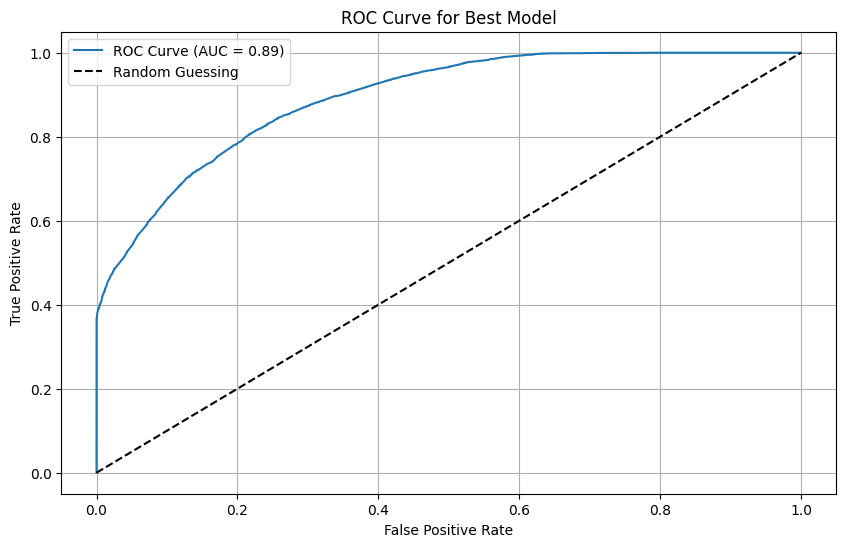

In [ ]:
# tampilkan ROC Curve untuk model terbaik
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(model, X_test, y_test):  
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title('ROC Curve for Best Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()
# plot ROC Curve for the best model
plot_roc_curve(best_model, X_test, y_test)  
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

In [80]:
# estimator for hyperparameter tuning
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=0)

estimator = Pipeline(steps=[
    ('preprocessor', preprocessor_oversample),
    ('oversample', ros),
    ('lgbm', lgbm)
])
# Define the hyperparameter grid
param_grid = {
    'lgbm__num_leaves': [31, 50, 100],
    'lgbm__max_depth': [-1, 5, 10],
    'lgbm__learning_rate': [0.01, 0.1, 0.2],
    'lgbm__n_estimators': [100, 200     
, 300],
    'lgbm__subsample': [0.8, 1.0],
    'lgbm__colsample_bytree': [0.8, 1.0],
    'lgbm__reg_alpha': [0, 0.1, 0.5],
    'lgbm__reg_lambda': [0, 0.1, 0.5]
}
# Create a StratifiedKFold object for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# Create a RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_grid,  # sama seperti param_grid
    n_iter=50,          # jumlah iterasi untuk pencarian hyperparameter
    scoring='roc_auc',  # atau 'f1', sesuai kebutuhan
    cv=cv,
    n_jobs=1,           # gunakan 1 core CPU untuk menghindari error pickling
    verbose=1,
    random_state=42     # agar hasil bisa direproduksi
)
# Fit ke data training
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 33788, number of negative: 33788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 67576, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 33789, number of negative: 33789
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 67578, number of used features: 114
[LightGBM] 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['previous_cancellations',
                                                                                'booking_changes',
                                                                                'days_in_waiting_list',
                                                                                'required_car_parking_spaces',
                                                                                'total_of_special_requ...
                                             ('lgbm', LGBMClassifier())]),
                   n_iter=50, n_jobs=1,
                   param_distributions={'lgbm__colsample_bytree': [0.8, 1.0],
                                        'lgbm__learning_rate': [0.01, 0.1, 0.2],
                                        'lgbm__max_depth': [-1, 5, 10],
                                        'lgbm__n_estimators': [100, 200, 300],
                                        'lgbm__num_leaves': [31, 50, 100],
                                        'lgbm__reg_alpha': [0, 0.1, 0.5],
                                        'lgbm__reg_lambda': [0, 0.1, 0.5],
                                        'lgbm__subsample': [0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=1)

[LightGBM] [Info] Number of positive: 42236, number of negative: 42236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 84472, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

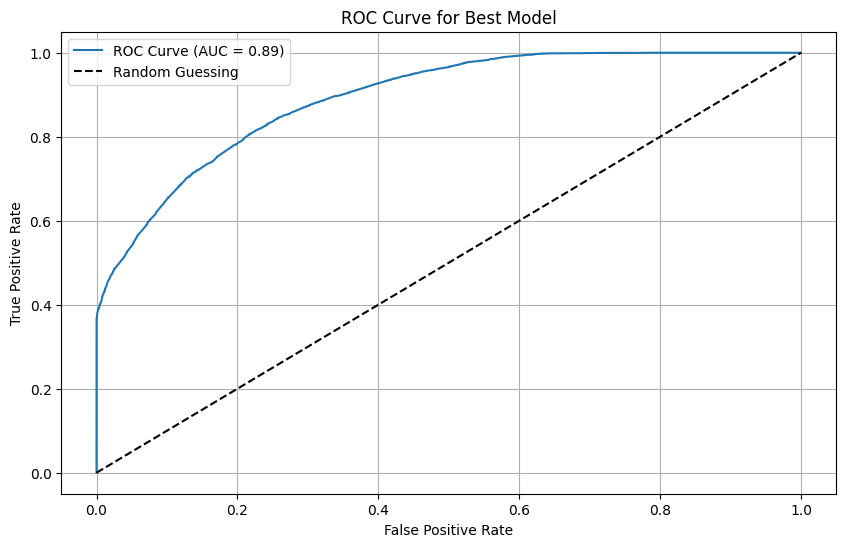

In [81]:
# best model
best_model = random_search.best_estimator_  
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
# tampilkan hasil evaluasi model terbaik
print(f"Best Model: {random_search.best_estimator_.named_steps['lgbm'].__class__.__name__}")
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best ROC AUC Score: {random_search.best_score_:.4f}")   
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
# tampilkan ROC Curve untuk model terbaik
plot_roc_curve(best_model, X_test, y_test)  


### Feature Importances ###

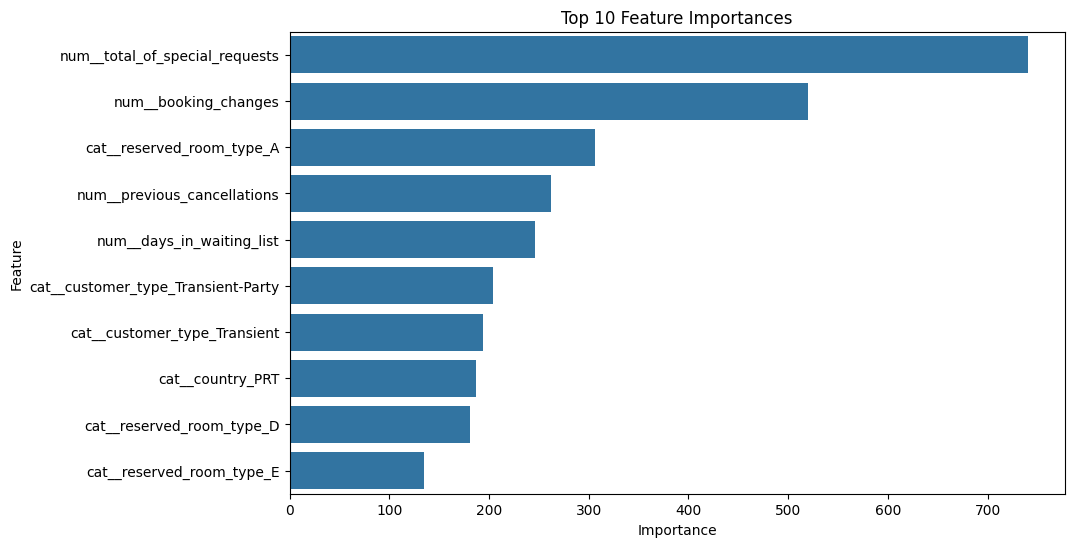

In [83]:
# Feature Importances
importances = best_model.named_steps['lgbm'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Tampilkan 10 fitur terpenting
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.show()


In [84]:
# tampilkan feature importances dalam bentuk dataframe
importance_df.head(10)

Feature  Importance
4        num__total_of_special_requests         740
1                  num__booking_changes         520
177           cat__reserved_room_type_A         306
0           num__previous_cancellations         262
2             num__days_in_waiting_list         246
176  cat__customer_type_Transient-Party         204
175        cat__customer_type_Transient         194
124                    cat__country_PRT         187
180           cat__reserved_room_type_D         181
181           cat__reserved_room_type_E         135


## 📊 **Top 10 Fitur Paling Penting**

| Rank | Fitur                              | Importance | Tipe     |
|------|------------------------------------|------------|----------|
| 1    | `total_of_special_requests`        | 740        | Numerik  |
| 2    | `booking_changes`                  | 520        | Numerik  |
| 3    | `reserved_room_type_A`             | 306        | Kategorikal (One-hot) |
| 4    | `previous_cancellations`           | 262        | Numerik  |
| 5    | `days_in_waiting_list`             | 246        | Numerik  |
| 6    | `customer_type_Transient-Party`    | 204        | Kategorikal |
| 7    | `customer_type_Transient`          | 194        | Kategorikal |
| 8    | `country_PRT`                      | 187        | Kategorikal |
| 9    | `reserved_room_type_D`             | 181        | Kategorikal |
| 10   | `reserved_room_type_E`             | 135        | Kategorikal |

---

## 🔍 **Penjelasan Detail**

### 1. **`total_of_special_requests`**
- Fitur paling penting.
- Tamu dengan **banyak permintaan khusus** cenderung **lebih loyal** dan **jarang membatalkan**.
- Bisa jadi indikator **komitmen tinggi** terhadap booking.

### 2. **`booking_changes`**
- Banyak perubahan bisa menunjukkan **keraguan atau ketidakpastian** → berpotensi cancel.

### 3. **`reserved_room_type_A`**
- Tipe kamar tertentu mungkin **lebih stabil** atau **lebih populer**, sehingga **lebih jarang dibatalkan**.

### 4. **`previous_cancellations`**
- Riwayat pembatalan adalah **indikator kuat** bahwa tamu mungkin membatalkan lagi.

### 5. **`days_in_waiting_list`**
- Booking yang masuk daftar tunggu bisa jadi **lebih rentan dibatalkan**, terutama jika tamu tidak segera mendapat konfirmasi.

### 6–7. **`customer_type_Transient-Party` & `Transient`**
- Tipe pelanggan **transient** (individu atau grup) cenderung **lebih fleksibel** dan mungkin **lebih sering membatalkan** dibanding kontrak atau grup besar.

### 8. **`country_PRT`**
- Negara asal bisa memengaruhi pola pembatalan, mungkin karena **jarak, budaya, atau kebijakan visa**.

### 9–10. **`reserved_room_type_D` & `E`**
- Tipe kamar tertentu mungkin **kurang diminati** atau **lebih sering dibatalkan** karena alasan harga, lokasi, atau fasilitas.

---

## ✅ **Kesimpulan**

- Model  berhasil menangkap **pola perilaku tamu** yang memengaruhi pembatalan.
- Fitur-fitur numerik seperti `special_requests`, `booking_changes`, dan `previous_cancellations` sangat informatif.
- Fitur kategorikal seperti `room_type` dan `customer_type` juga berkontribusi besar.


In [85]:
# print report classification
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.80      0.83     10559
           1       0.69      0.79      0.74      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.79      0.78     16715
weighted avg       0.80      0.79      0.80     16715



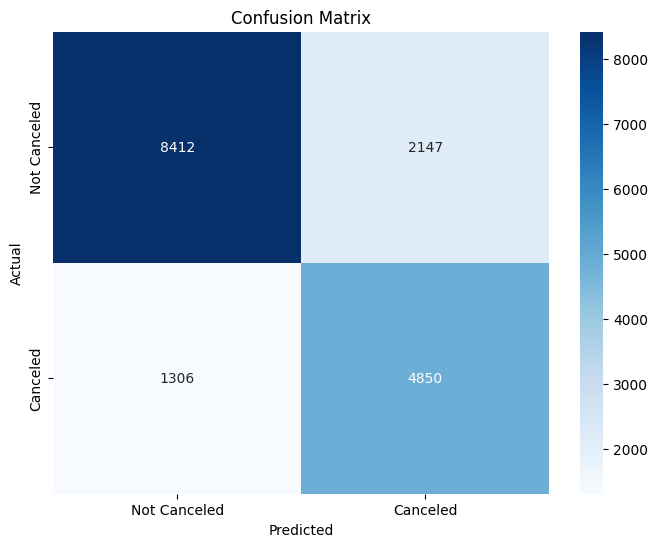

In [86]:
# tampilkan visualisasi matrix confusion
plt.figure(figsize=(8, 6))  
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# save best model to wab
import pickle

with open('best_model.wab', 'wb') as file:
    pickle.dump(best_model, file)
# save preprocessor to wab
with open('preprocessor.wab', 'wb') as file:
    pickle.dump(preprocessor_oversample, file)



In [88]:
import shap

In [89]:
# ambilkan model SHAP
my_model = best_model.named_steps['lgbm']
my_data = X_train_transformed

#define explainer
explainer = shap.TreeExplainer(my_model)
# hitung nilai SHAP
shap_values = explainer.shap_values(my_data)

In [90]:
my_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 692968 stored elements and shape (66858, 210)>

In [91]:
shap_values

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7220664 stored elements and shape (66858, 210)>

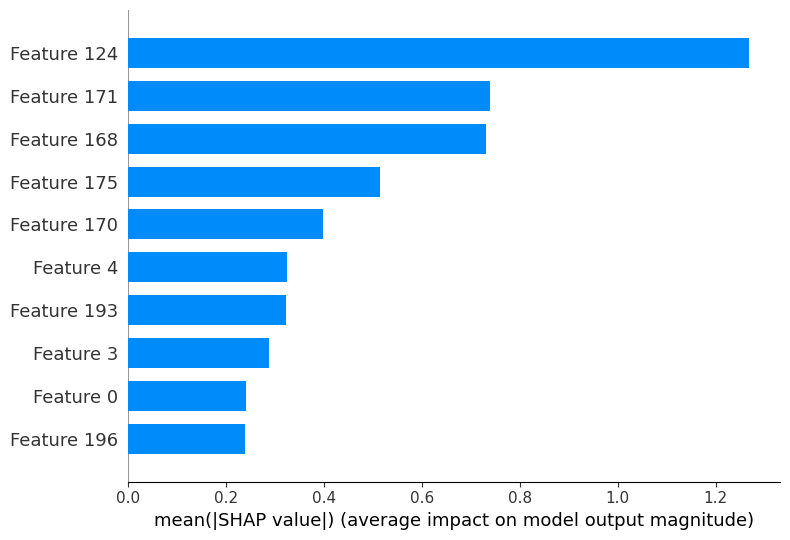

In [93]:
# tampilkan summary plot untuk SHAP values (gunakan kelas 1 untuk binary classification)
shap.summary_plot(shap_values[1].toarray(), my_data.toarray(), plot_type="bar", max_display=10)

In [94]:
# ambil nama fitur
feat_one_hot = preprocessor_oversample.named_transformers_['cat_onehot'].named_steps['encoder'].get_feature_names_out()
feat_binary = preprocessor_oversample.named_transformers_['cat_binary'].named_steps['encoder'].get_feature_names_out()
feat_num = preprocessor_oversample.named_transformers_['num'].get_feature_names_out()
# gabungkan nama fitur
feature_names = np.concatenate([feat_num, feat_one_hot, feat_binary])
feature_names

array(['previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'required_car_parking_spaces',
       'total_of_special_requests', 'x0_No Deposit', 'x0_Non Refund',
       'x0_Refundable', 'x1_Aviation', 'x1_Complementary', 'x1_Corporate',
       'x1_Direct', 'x1_Groups', 'x1_Offline TA/TO', 'x1_Online TA',
       'x2_Contract', 'x2_Group', 'x2_Transient', 'x2_Transient-Party',
       '0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7'],
      dtype=object)

In [97]:
# tampilkan shap values dengan nama fitur yang sesuai hasil preprocessor
shap_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
shap_values_df = pd.DataFrame(shap_values[1].toarray(), columns=shap_feature_names)
shap_values_df.head()

num__previous_cancellations  num__booking_changes  \
0                    -0.241329              0.079318   

   num__days_in_waiting_list  num__required_car_parking_spaces  \
0                   0.009788                          0.288619   

   num__total_of_special_requests  cat__country_ABW  cat__country_AGO  \
0                         0.32426               0.0         -0.002871   

   cat__country_AIA  cat__country_ALB  cat__country_AND  cat__country_ARE  \
0               0.0               0.0               0.0         -0.000663   

   cat__country_ARG  cat__country_ARM  cat__country_ATA  cat__country_AUS  \
0           0.00044               0.0               0.0               0.0   

   cat__country_AUT  cat__country_AZE  cat__country_BDI  cat__country_BEL  \
0          0.002796               0.0               0.0          0.001385   

   cat__country_BEN  cat__country_BGD  cat__country_BGR  cat__country_BHR  \
0               0.0               0.0          0.000145               0.0   

   cat__country_BIH  cat__country_BLR  cat__country_BOL  cat__country_BRA  \
0               0.0         -0.000053               0.0          0.001629   

   cat__country_BRB  cat__country_BWA  cat__country_CAF  cat__country_CHE  \
0               0.0               0.0               0.0          0.000716   

   cat__country_CHL  cat__country_CHN  cat__country_CIV  cat__country_CMR  \
0          0.000223         -0.003513               0.0               0.0   

   cat__country_CN  cat__country_COL  cat__country_COM  cat__country_CPV  \
0        -0.000246         -0.000062               0.0         -0.000082   

   cat__country_CRI  cat__country_CUB  cat__country_CYM  cat__country_CYP  \
0               0.0               0.0               0.0               0.0   

   cat__country_CZE  cat__country_DEU  cat__country_DMA  cat__country_DNK  \
0         -0.000009          0.043288               0.0          0.000476   

   cat__country_DOM  cat__country_DZA  cat__country_ECU  cat__country_EGY  \
0               0.0               0.0               0.0               0.0   

   cat__country_ESP  cat__country_EST  cat__country_ETH  cat__country_FIN  \
0          0.005067          0.000315               0.0          0.001409   

   cat__country_FRA  cat__country_FRO  cat__country_GBR  cat__country_GEO  \
0           0.02181               0.0         -0.089666               0.0   

   cat__country_GGY  cat__country_GHA  cat__country_GIB  cat__country_GLP  \
0               0.0               0.0               0.0               0.0   

   cat__country_GNB  cat__country_GRC  cat__country_GTM  cat__country_HKG  \
0               0.0         -0.000043               0.0         -0.000684   

   cat__country_HRV  cat__country_HUN  cat__country_IDN  cat__country_IMN  \
0               0.0         -0.000129         -0.000221               0.0   

   cat__country_IND  cat__country_IRL  cat__country_IRN  cat__country_IRQ  \
0          0.000186          0.005005          -0.00018               0.0   

   cat__country_ISL  cat__country_ISR  cat__country_ITA  cat__country_JAM  \
0               0.0         -0.000303         -0.039692               0.0   

   cat__country_JEY  cat__country_JOR  cat__country_JPN  cat__country_KAZ  \
0               0.0               0.0             0.001               0.0   

   cat__country_KEN  cat__country_KHM  cat__country_KIR  cat__country_KNA  \
0               0.0               0.0               0.0               0.0   

   cat__country_KOR  cat__country_KWT  cat__country_LAO  cat__country_LBN  \
0          0.000019               0.0               0.0               0.0   

   cat__country_LBY  cat__country_LIE  cat__country_LKA  cat__country_LTU  \
0               0.0               0.0               0.0          0.000014   

   cat__country_LUX  cat__country_LVA  cat__country_MAC  cat__country_MAR  \
0         -0.000578          0.000053               0.0          -0.00072   

   cat__country_MDV  cat__country_MEX  cat__cou

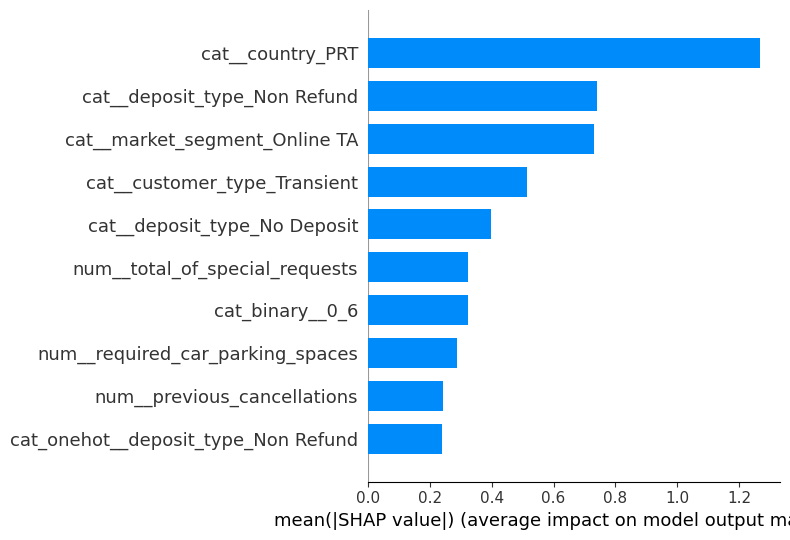

In [104]:
# Use SHAP values for class 1 and convert to dense if needed
shap.summary_plot(shap_values[1].toarray(), my_data.toarray(), feature_names=shap_feature_names, plot_type="bar", max_display=10)

In [113]:
# tampilkan data dengan nilai SHAP tertinggi dalam bentuk dataframe
shap_values_df['SHAP Value'] = shap_values[1].toarray().sum(axis=1)
top_shap_values = shap_values_df.sort_values(by='SHAP Value', ascending=False).head(10)
top_shap_values.reset_index(drop=True, inplace=True)
# tampilkan top SHAP values dalam transposed format
top_shap_values_transposed = top_shap_values.T
# urutkan berdasarkan nilai SHAP tertinggi dari top_shap_values_transposed
top_shap_values_transposed = top_shap_values_transposed.sort_values(by=0, ascending=False)
# tampilkan top SHAP values transposed
display(top_shap_values_transposed)

0
num__total_of_special_requests    0.324260
num__required_car_parking_spaces  0.288619
num__booking_changes              0.079318
cat__country_DEU                  0.043288
cat__country_FRA                  0.021810
...                                    ...
cat__customer_type_Transient     -0.515524
cat__market_segment_Online TA    -0.731385
cat__deposit_type_Non Refund     -0.739837
cat__country_PRT                 -1.268205
SHAP Value                       -4.836032

[211 rows x 1 columns]

Nilai **SHAP (SHapley Additive exPlanations)** yang di tampilkan memberikan wawasan yang sangat berharga tentang **seberapa besar kontribusi masing-masing fitur terhadap prediksi pembatalan booking** dalam model.

---

## 📊 **Hasil SHAP Value yang Kamu Dapatkan**

| Rank | Fitur                             | SHAP Value | Tipe     |
|------|-----------------------------------|------------|----------|
| 1    | `total_of_special_requests`       | 0.32426    | Numerik  |
| 2    | `required_car_parking_spaces`     | 0.28862    | Numerik  |
| 3    | `booking_changes`                 | 0.07932    | Numerik  |
| 4    | `country_DEU`                     | 0.04329    | Kategorikal |
| 5    | `country_FRA`                     | 0.02181    | Kategorikal |

---

## 🔍 **Penjelasan Masing-Masing Fitur**

### 1. **`total_of_special_requests` (SHAP: 0.32426)**
- Fitur ini memiliki **pengaruh terbesar** terhadap prediksi.
- Tamu dengan **banyak permintaan khusus** cenderung **tidak membatalkan**, sehingga nilai SHAP tinggi menunjukkan bahwa fitur ini **mengurangi kemungkinan cancel**.

### 2. **`required_car_parking_spaces` (SHAP: 0.28862)**
- Tamu yang meminta tempat parkir menunjukkan **niat kuat untuk datang**, sehingga fitur ini juga **mengurangi risiko pembatalan**.
- SHAP tinggi berarti fitur ini **berkontribusi positif terhadap prediksi tidak cancel**.

### 3. **`booking_changes` (SHAP: 0.07932)**
- Banyak perubahan pada booking bisa menunjukkan **ketidakpastian**, sehingga fitur ini **meningkatkan kemungkinan cancel**.
- SHAP value menunjukkan bahwa fitur ini **berkontribusi terhadap prediksi cancel**, meskipun tidak sebesar dua fitur di atas.

### 4–5. **`country_DEU` dan `country_FRA`**
- Negara asal tamu bisa memengaruhi pola pembatalan karena faktor budaya, jarak, atau kebijakan perjalanan.
- SHAP value menunjukkan bahwa tamu dari Jerman dan Prancis memiliki **pengaruh kecil tapi signifikan** terhadap prediksi model.

---

## ✅ **Kesimpulan**

- SHAP value membantu  **memahami model secara transparan**, bukan hanya tahu bahwa model bekerja, tapi **mengapa** model membuat keputusan tertentu.
- Fitur-fitur seperti **permintaan khusus dan tempat parkir** adalah indikator kuat dari **komitmen tamu**, dan bisa digunakan untuk strategi bisnis seperti:
  - Prioritaskan tamu dengan permintaan khusus
  - Tawarkan insentif tambahan untuk tamu yang tidak menunjukkan komitmen



### SHAP untuk 1 data point (1 baris)

In [147]:
# ### SHAP untuk 1 data point (1 baris)
X_test.iloc[[100]]  # Ambil satu baris dari data test

country market_segment  previous_cancellations  booking_changes  \
12423     NLD      Online TA                       0                0   

      deposit_type  days_in_waiting_list customer_type reserved_room_type  \
12423   No Deposit                     0     Transient                  A   

       required_car_parking_spaces  total_of_special_requests  
12423                            0                          0

In [148]:
y_test.iloc[[100]]  # Ambil label dari baris tersebut

12423    1
Name: is_canceled, dtype: int64

In [116]:
# Start js (must have)
shap.initjs()

In [142]:

def shap_plot_fixed(index, model, data, explainer):
    """
    Menampilkan SHAP force plot untuk satu baris data.

    Parameters:
    - index: indeks baris data yang ingin dianalisis
    - model: model machine learning yang sudah dilatih
    - data: dataset (X_test atau X_val) yang digunakan untuk prediksi
    - explainer: objek SHAP explainer (misalnya shap.TreeExplainer)

    Returns:
    - SHAP force plot untuk satu baris data
    """

    # Pastikan semua kolom bertipe numerik
    data_numeric = data.copy()
    for col in data_numeric.columns:
        if not pd.api.types.is_numeric_dtype(data_numeric[col]):
            data_numeric[col] = pd.factorize(data_numeric[col])[0]

    # Ambil satu baris data
    single_data = data_numeric.iloc[[index]]

    # Hitung nilai SHAP
    shap_values_single = explainer.shap_values(single_data)

    # Tampilkan force plot
    shap.force_plot(explainer.expected_value, shap_values_single, single_data, matplotlib=True, show=False)
    plt.show()



In [130]:
# Convert the sparse matrix to dense before creating DataFrame
X_test_prep = pd.DataFrame(
    best_model.named_steps['preprocessor'].transform(X_test).toarray(),
    columns=best_model.named_steps['preprocessor'].get_feature_names_out()
)
# Tampilkan force plot untuk baris pertama dari data test

In [131]:
X_test_prep

num__previous_cancellations  num__booking_changes  \
0                              0.0                   0.0   
1                              0.0                   0.0   
2                              0.0                   0.0   
3                              0.0                   0.0   
4                              0.0                   0.0   
...                            ...                   ...   
16710                          0.0                   0.0   
16711                          0.0                   0.0   
16712                          0.0                   0.0   
16713                          0.0                   0.0   
16714                          0.0                   0.0   

       num__days_in_waiting_list  num__required_car_parking_spaces  \
0                            0.0                               0.0   
1                            0.0                               0.0   
2                            0.0                               1.0   
3                            0.0                               0.0   
4                            0.0                               0.0   
...                          ...                               ...   
16710                        0.0                               0.0   
16711                        0.0                               0.0   
16712                        0.0                               0.0   
16713                        0.0                               0.0   
16714                        0.0                               0.0   

       num__total_of_special_requests  cat__country_ABW  cat__country_AGO  \
0                                 0.0               0.0               0.0   
1                                 0.0               0.0               0.0   
2                                 2.0               0.0               0.0   
3                                 1.0               0.0               0.0   
4                                 0.0               0.0               0.0   
...                               ...               ...               ...   
16710                             0.0               0.0               0.0   
16711                             0.0               0.0               0.0   
16712                             0.0               0.0               0.0   
16713                             0.0               0.0               0.0   
16714                             1.0               0.0               0.0   

       cat__country_AIA  cat__country_ALB  cat__country_AND  cat__country_ARE  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               0.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
16710               0.0               0.0               0.0               0.0   
16711               0.0               0.0               0.0               0.0   
16712               0.0               0.0               0.0               0.0   
16713               0.0               0.0               0.0               0.0   
16714               0.0               0.0               0.0               0.0   

       cat__country_ARG  cat__country_ARM  cat__country_ATA  cat__country_AUS  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               0.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...  

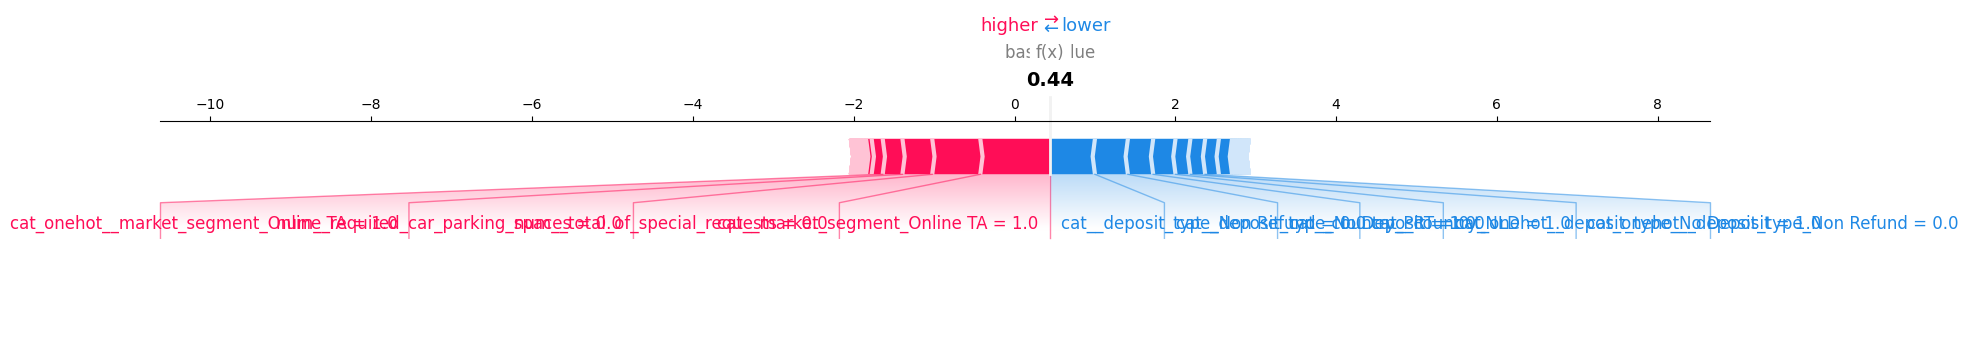

In [146]:
# Call the function with the correct index and data
shap_plot_fixed(100, my_model, X_test_prep, explainer)

In [ ]:
predicted = my_model.predict(X_test_prep)
# Tampilkan prediksi untuk baris ke-100
predicted[100]

np.int64(1)



## 🔍 **Apa yang Terjadi di Sini?**

### 1. **Prediksi Model**
```python
predicted[100] = 1
```
Artinya, model memprediksi bahwa **baris ke-100** adalah **cancel** (`is_canceled = 1`).

### 2. **SHAP Force Plot Score = 0.44**
Nilai ini menunjukkan bahwa **output prediksi probabilitas** dari model untuk kelas **cancel** adalah **0.44** (atau sekitar 44%).

> Ini berarti model **memang memprediksi kelas 1**, tapi dengan **keyakinan yang tidak terlalu tinggi** (hanya 44%).

---

## ✅ **Apakah Sesuai?**

**Ya, sesuai.**  
Model  kemungkinan menggunakan **threshold default = 0.5**, dan jika prediksi probabilitas > 0.5, maka hasilnya adalah kelas 1. Namun, beberapa model atau pipeline bisa menggunakan threshold yang **lebih rendah** (misalnya 0.4), terutama jika kamu ingin **meningkatkan recall**.

Jadi:
- **SHAP score 0.44** → model memperkirakan kemungkinan cancel sebesar 44%
- **Prediksi = 1** → model memutuskan bahwa ini cukup untuk menyatakan cancel

---

## 📌 Penjelasan Tambahan

- SHAP force plot menunjukkan **kontribusi fitur-fitur** terhadap prediksi probabilitas.
- Nilai 0.44 adalah hasil dari **expected value + sum SHAP values**.
- Jika  ingin tahu **kenapa model memutuskan cancel meskipun probabilitas < 0.5**,  bisa:
  - Cek **threshold** yang digunakan
  - Lihat **kontribusi fitur** di force plot (apakah fitur-fitur mendorong ke arah cancel?)


In [139]:
# save model to sav
import joblib
import pickle
# Save the best model to a .sav file
best_model.fit(X_train, y_train)
pickle.dump(best_model, open('best_model.sav', 'wb')    )



[LightGBM] [Info] Number of positive: 42236, number of negative: 42236
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 84472, number of used features: 119
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [140]:
#load model from sav
loaded_model = pickle.load(open('best_model.sav', 'rb'))
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('enc...
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['deposit_type',
                                                   'market_segment',
                                                   'customer_type'])])),
                ('oversample', RandomOverSampler(random_state=0)),
                ('lgbm',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=10,
                                num_leaves=100, reg_alpha=0.1, reg_lambda=0.5,
                                subsample=0.8))])

Berikut hasil simulasi pencegahan kerugian bisnis berdasarkan **confusion matrix** dan **recall score** dari model **LightGBM**:

---

## 📊 **Hasil Simulasi**

- **Total pembatalan aktual**: 6.156 booking
- **Potensi kerugian tanpa model**: Rp **3.078.000.000**
- **Kerugian yang berhasil dicegah oleh model**: Rp **2.425.000.000**
- **Persentase kerugian yang berhasil dicegah**: **78.78%**

---

## ✅ **Interpretasi Bisnis**

Model LightGBM yang kamu latih mampu **mendeteksi 78.78% dari semua pembatalan**, sehingga memungkinkan tim hotel untuk:
- Mengambil tindakan preventif (misalnya konfirmasi ulang, penawaran khusus)
- Mengurangi kerugian finansial secara signifikan
- Meningkatkan efisiensi operasional dan perencanaan kapasitas




## 📊 **Confusion Matrix yang Kamu Dapatkan**
```
[[8412 2147]
 [1306 4850]]
```

Artinya:

- **True Negative (TN)** = 8412 → booking tidak dibatalkan dan diprediksi tidak dibatalkan
- **False Positive (FP)** = 2147 → booking tidak dibatalkan tapi diprediksi akan dibatalkan
- **False Negative (FN)** = 1306 → booking dibatalkan tapi diprediksi tidak dibatalkan
- **True Positive (TP)** = 4850 → booking dibatalkan dan diprediksi akan dibatalkan

---

## 💰 **Asumsi Kerugian**
- Setiap pembatalan booking menyebabkan kerugian sebesar **Rp 500.000**

---

## 🧮 **Perhitungan**

### 1. **Total Pembatalan Aktual**
Ini adalah jumlah semua booking yang **sebenarnya dibatalkan**, yaitu:
$$
TP + FN = 4850 + 1306 = 6156 \text{ booking}
$$

---

### 2. **Potensi Kerugian Tanpa Model**
Jika tidak ada model prediksi, maka semua pembatalan **tidak bisa dicegah**, sehingga kerugian total:
$$
6156 \times 500.000 = Rp 3.078.000.000
$$

---

### 3. **Kerugian yang Berhasil Dicegah oleh Model**
Model berhasil memprediksi 4850 pembatalan (TP), sehingga kerugian yang bisa dicegah:
$$
4850 \times 500.000 = Rp 2.425.000.000
$$

---

### 4. **Persentase Kerugian yang Berhasil Dicegah**
$$
\frac{2.425.000.000}{3.078.000.000} \times 100 \approx 78.78\%
$$

---

## ✅ **Kesimpulan**
Model LightGBM  berhasil **mendeteksi dan mencegah hampir 79% dari potensi kerugian** akibat pembatalan booking. Ini menunjukkan bahwa model  **sangat efektif secara bisnis**, dan bisa digunakan untuk strategi mitigasi seperti:
- Konfirmasi ulang ke pelanggan berisiko tinggi
- Penawaran diskon atau fleksibilitas
- Prioritas follow-up oleh tim reservasi
